In [246]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# from nn_train import do_job
import random

# cna not import into global namespace  for multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [247]:
EARLIEST_DATE = '2012-01-01'
N_COMPONENTS=100

# REad in data

In [262]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
#         try:
#             df_.index = df_.date
#             df_.drop('date', inplace=True)
#         except ValueError:
#             pass
        # ensure we have the most recent data
        try:
            most_recent_date = pd.to_datetime(df_.date.max())
            oldest_date = pd.to_datetime(df_.date.min())
        except Exception:
            continue
        
        oldest_date_bool = oldest_date < datetime.datetime(2014,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [263]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,5,29).date())

Reading in wal
Reading in fsbw
Reading in pfbc
Reading in hasi
Reading in mtb
Reading in rbb
Stock rbb most recent date is 2020-05-29 00:00:00 oldest date is 2017-07-26 00:00:00. Skipping it
Reading in umpq
Reading in jpm
Reading in vfh
Reading in iwm
Reading in cvbf
Reading in fitb
Reading in irm
Reading in wfc
Reading in cwbc
Reading in bsrr
Reading in key
Reading in ewbc
Reading in dlr
Reading in spy
Reading in ibuy
Stock ibuy most recent date is 2020-05-29 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in ftc
Stock ftc most recent date is 2020-05-29 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in ubfo
Reading in hope
Reading in cvcy
Reading in pacw
Reading in ntrs
Reading in agnc
Reading in cma
Reading in qqq
Reading in nrz
Reading in gbci
Reading in hiw
Reading in pbj
Reading in vti
Reading in sui
Reading in c
Reading in colb
Reading in inn
Stock inn most recent date is 2020-05-29 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Readin

In [264]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

3306

In [265]:
len(dict_of_stocks_and_dfs.keys())

58

# Create correlation features

In [266]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3,5, 7, 10, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [267]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [268]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

In [269]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [270]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.017241379310344827 pct of stocks


Finished 0.034482758620689655 pct of stocks


Finished 0.05172413793103448 pct of stocks


Finished 0.06896551724137931 pct of stocks


Finished 0.08620689655172414 pct of stocks


Finished 0.10344827586206896 pct of stocks


Finished 0.1206896551724138 pct of stocks


Finished 0.13793103448275862 pct of stocks


Finished 0.15517241379310345 pct of stocks


Finished 0.1724137931034483 pct of stocks


Finished 0.1896551724137931 pct of stocks


Finished 0.20689655172413793 pct of stocks


Finished 0.22413793103448276 pct of stocks


Finished 0.2413793103448276 pct of stocks


Finished 0.25862068965517243 pct of stocks


Finished 0.27586206896551724 pct of stocks


Finished 0.29310344827586204 pct of stocks


Finished 0.3103448275862069 pct of stocks


Finished 0.3275862068965517 pct of stocks


Finished 0.3448275862068966 pct of stocks


Finished 0.3620689655172414 pct of stocks


Finished 0.3793103448275862 pct

In [271]:
# max number of stocks is ~300 NOT 990

In [272]:
len(final_stock_df.columns)

12445

In [273]:
len(final_stock_df.columns)

12445

# Prep code for NN

In [274]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', 
                    start_idx=0, n_val=50, print_idx=100, input_verbose=1,     n_pca_components=100): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx and input_verbose == 1:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and (i != 0) and input_verbose==1:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx and input_verbose==1:
            print(f"Val idx start at {val_start_idx}")
        if (i % print_idx == 0) and i != 0 and input_verbose==1:
            print(f"Pct finished for val sequences = {i/n_sequences}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) and input_verbose==1:
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        
        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    

    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    
    pca_scalers = {}

    new_X = np.zeros((X.shape[0], X.shape[1], n_pca_components))
    for i in range(X.shape[1]):
        pca_scalers[i] = PCA(n_components=n_pca_components) # ~80%
        new_X[:, i, :] = pca_scalers[i].fit_transform(X[:, i, :]) 


    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  

    new_X_val = np.zeros((X_val.shape[0], X_val.shape[1], n_pca_components))
    for i in range(X_val.shape[1]):
        new_X_val[:, i, :] = pca_scalers[i].transform(X_val[:, i, :]) 
        
   # need  to do this again as standard scaler may have nans
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
    print('X val shape', X_val.shape)
    

    
    return new_X, y, new_X_val, y_val, scalers, pca_scalers

    
    

In [275]:
X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
    final_stock_df,
    30, start_idx=0, input_verbose=0,
    n_val=40, y_col=f"lb_lind_close_corr_rolling_7_days"
) # 30 steps

ValueError: This y col does not exist in this df

In [276]:
def build_keras_model(n_steps, n_features, n_units=100, dropout_pct=0.02, n_layers = 1):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

# Train a model

In [277]:
np.sqrt(.4)

0.6324555320336759

In [308]:
# train on all data
# predict for the upcoming week

# 
def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, print_idx=25, n_day_sequences=14, 
                                 start_date_training_data='2009-01-01', n_validation_sequences=20, input_batch_size=128, 
                                 input_verbose=0, min_val_mse_threshold=0.25, n_pca_components=100):
    """
    The main entrypoint for training an LSTM network on stock predictions
    
    :param final_stock_df: The list of stock pairs with correlations over different time ranges, volume
    :para pairs_of_stocks: The list of stock pairs
    :param print_idx: The number of iterations to pass before printing out progress
    :param n_day_sequences: The number of sequences to pass to the LSTM (i.e. the number of days)
    :param start_date_training_data: Filter for data before thie date to train on
    :param n_validation_sequences: Number of sequences to validate on. Should be >= 20
    :param input_batch_size: size of the batches for training NN
    :parm input_verbose: if 1, print out everything otherwise, don't
    :param min_val_mse_threshold: the minimum val mse in order to consider these stocks predictions for the upcoming week. 
    :param n_pca_components: Number of components for PCA. 100 is >99% of variance
    """
    #validate
    if n_validation_sequences < 20:
        raise ValueError('Incorrect n_validation_sequences')
    
    n_stock_missed_val_threshold = 0
    # validation needs to be 40 or index error
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)



    test_df = final_stock_df.iloc[-n_day_sequences:, :]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start_final_time = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')

        first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
        print('pred_col_name', pred_col_name)

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}", n_pca_components=n_pca_components
        ) # 30 steps
        
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                           # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = test_X.reshape(1, test_X.shape[0], test_X.shape[1])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        new_X_test = np.zeros((test_X.shape[0], test_X.shape[1], n_pca_components))
        for i in range(test_X.shape[1]):
            new_X_test[:, i, :] = pca_scalers[i].transform(test_X[:, i, :]) 

        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            print('building model')
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            print(smaller_model.summary())
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, restore_best_weights=True)
            print('starting training')
            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=800, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)

            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=200, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-200:, :].plot()
        min_val_mse = np.min(history_df['val_mse'])
        min_train_mse = np.min(history_df['mse'])
        plt.show()
        prediction = smaller_model.predict(new_X_test)[0][0] 

        if idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if idx % print_idx==0:
            print(f"Last corr = {last_corr}")
        
        if (min_val_mse <= min_val_mse_threshold) and (min_train_mse <= min_val_mse_threshold):
            pred_dates.append(most_recent_date)
            predicted_corr.append(prediction)
            last_corr_for_prediction_day.append(last_corr)
        else:
            pred_dates.append(most_recent_date)
            predicted_corr.append('too_high_of_mse')
            last_corr_for_prediction_day.append(last_corr)
            n_stock_missed_val_threshold+=1
        
        if input_verbose==1 and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False
        
        # write the predictions for every predictions
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


    end_final_time = time.time()

    print(f"Predictions took {(end_final_time-start_final_time)/60} mins")

    squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

    prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2
                 })
    
#     if job_id:
#         tmp_filepath = '../data/lstm_tmp_prediction_dfs'
#         if not os.path.isdir(f"{tmp_filepath}"):
#             os.mkdir(f"{tmp_filepath}")
#         prediction_df.to_csv(
#         f'{tmp_filepath}/{job_id}_lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
#     else:
  


In [309]:
len(pairs_of_stocks)

1653

In [310]:
# def chunks(l, n):
#     return [l[i:i+n] for i in range(0, len(l), n)]



# def dispatch_jobs(data, job_number, pairs):
#     total = len(pairs)
#     chunk_size = total / job_number
#     slice = chunks(pairs, int(chunk_size))
#     jobs = []
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1
#     pair = slice[0]
#     print(pair)
#     executor.map(do_job, (pair, data, 1))


# #     for i, pair in enumerate(slice):
# #         print(i)
        
# #         j = Process(target=do_job, args=(i, pair, data))
# #         jobs.append(j)
        

# #         executor.map(do_job, (i, pair, data))


        
# #         executor.submit(do_job)
# #     for j in jobs:
# #         j.start()
        
# # def main():
# #     executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)
# #     task1 = executor.submit(task)
# #     task2 = executor.submit(task)acorr

In [311]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

# # # from external import just_print

# executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)


# if __name__ == '__main__':
#     num_workers=3
# #     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])
    
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1


#     executor.map(do_job, (pairs_of_stocks[:10], final_stock_df, 1))

In [312]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)
#     final_stock_df = final_stock_df.dropna()
#     num_workers = mp.cpu_count()  
#     num_workers=2
#     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])

In [313]:

random.shuffle(pairs_of_stocks)

In [315]:
len(pairs_of_stocks)

1653

pred_col_name jpm_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
building model
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 14, 100)           80400     
____________________________________________

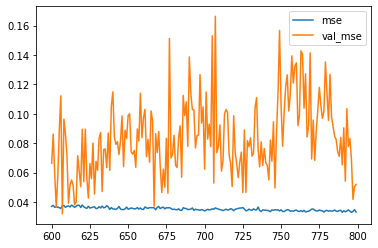

Prediction = 0.40799859166145325
Last corr = 0.242482
pred_col_name vti_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.316277229785919  minutes


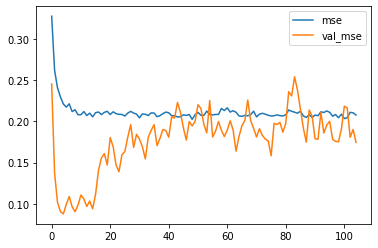

Prediction = 0.6632429957389832
Last corr = 0.926729
pred_col_name usb_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping
1.7169205983479818  minutes


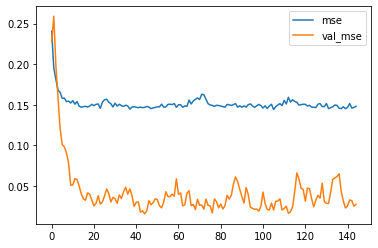

Prediction = 0.9769237041473389
Last corr = 0.941122
pred_col_name cvbf_c_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.3364872495333353  minutes


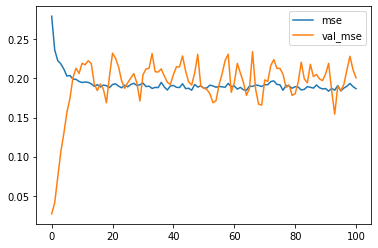

Prediction = 0.7401101589202881
Last corr = 0.773328
pred_col_name usb_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2055442134539287  minutes


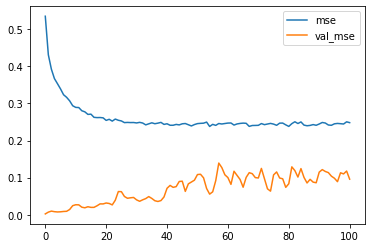

Prediction = 0.9131638407707214
Last corr = 0.892338
pred_col_name pfbc_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
1.3190163493156433  minutes


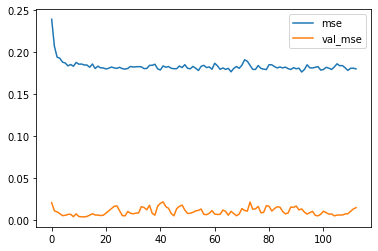

Prediction = 0.9191218614578247
Last corr = 0.975954
pred_col_name cwbc_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.3264726161956788  minutes


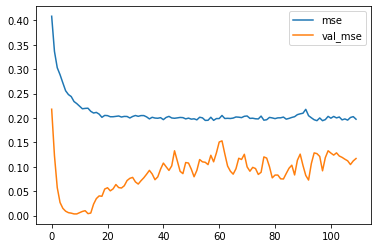

Prediction = 0.49519556760787964
Last corr = 0.603808
pred_col_name hasi_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3475488702456158  minutes


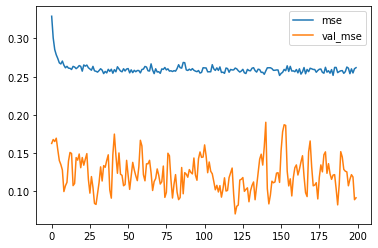

Prediction = 0.4033588767051697
Last corr = 0.113292
pred_col_name sui_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2358154654502869  minutes


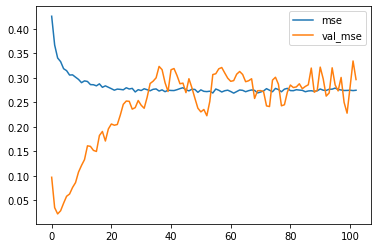

Prediction = 0.6845657825469971
Last corr = 0.856487
pred_col_name key_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.2917405645052593  minutes


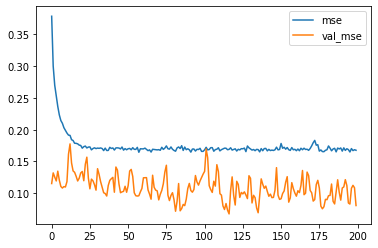

Prediction = 0.7174943089485168
Last corr = 0.956625
pred_col_name bjk_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.305374018351237  minutes


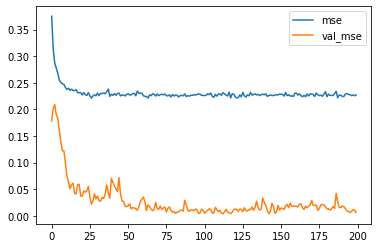

Prediction = 0.917351484298706
Last corr = 0.907932
pred_col_name bsrr_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1968465328216553  minutes


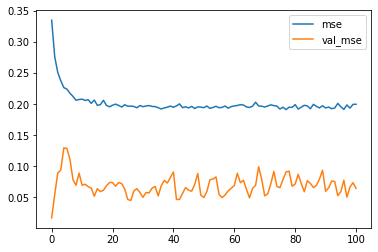

Prediction = 0.8273486495018005
Last corr = 0.833357
pred_col_name spy_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.1928542812665304  minutes


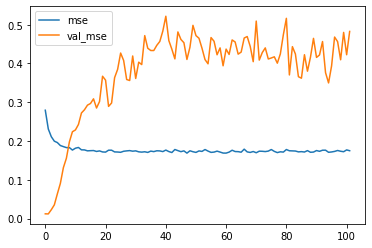

Prediction = 0.7776066064834595
Last corr = 0.90433
pred_col_name pfbc_gbci_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3316699504852294  minutes


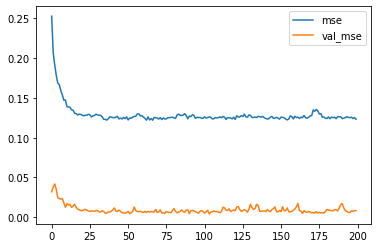

Prediction = 0.9287629723548889
Last corr = 0.975525
pred_col_name iwm_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1839895168940227  minutes


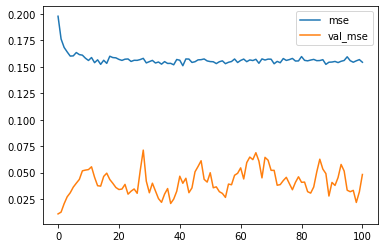

Prediction = 1.0334367752075195
Last corr = 0.962177
pred_col_name vfh_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.248622767130534  minutes


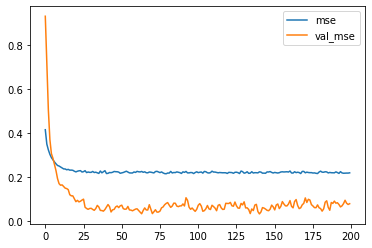

Prediction = 0.31439009308815
Last corr = 0.108046
pred_col_name gbci_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00187: early stopping
2.162147303422292  minutes


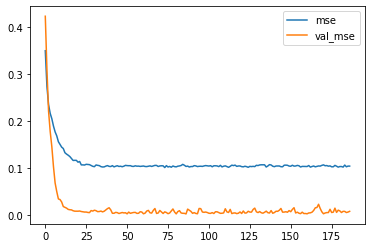

Prediction = 0.9123539328575134
Last corr = 0.929938
pred_col_name hiw_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.3044747710227966  minutes


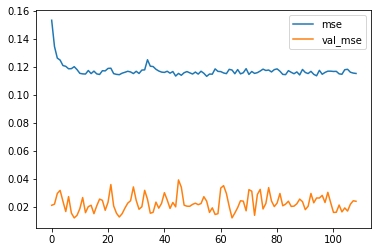

Prediction = 0.9242275357246399
Last corr = 0.974603
pred_col_name vti_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
1.5270350972811382  minutes


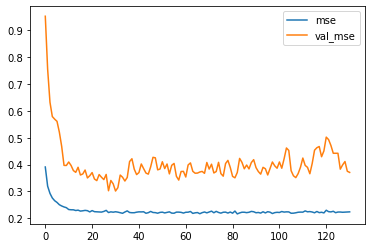

Prediction = 0.4879534840583801
Last corr = -0.078982
pred_col_name bsrr_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.214537250995636  minutes


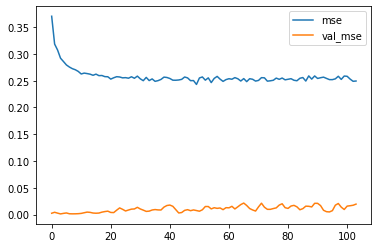

Prediction = 0.5329355001449585
Last corr = 0.506255
pred_col_name hiw_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2108335653940836  minutes


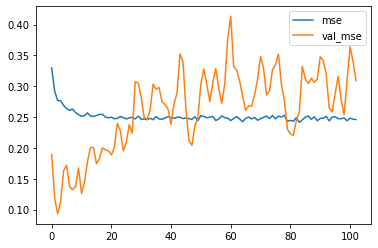

Prediction = 0.5854427814483643
Last corr = 0.931767
pred_col_name cma_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
1.4492246826489767  minutes


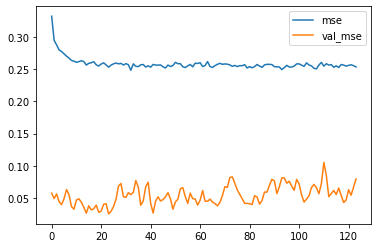

Prediction = 0.7267763614654541
Last corr = 0.817023
pred_col_name gbci_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.2902315338452657  minutes


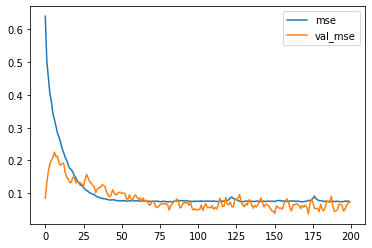

Prediction = 0.6843063831329346
Last corr = 0.950687
pred_col_name umpq_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1855678955713909  minutes


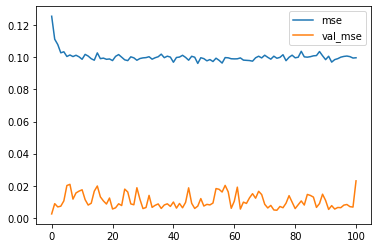

Prediction = 1.0183522701263428
Last corr = 0.975057
pred_col_name cma_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1950941642125448  minutes


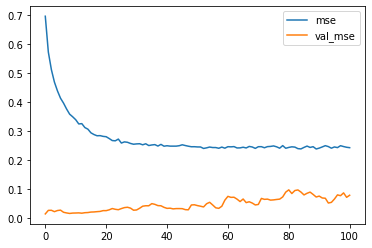

Prediction = 0.9535794258117676
Last corr = 0.899304
pred_col_name dia_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3992245316505434  minutes


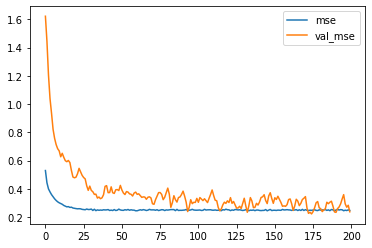

Prediction = 0.27250662446022034
Last corr = -0.253438
pred_col_name vti_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.334417402744293  minutes


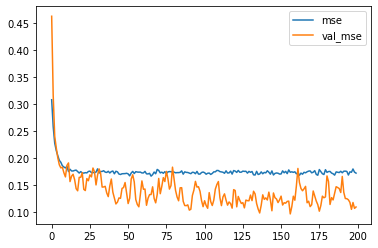

Prediction = 0.7178823947906494
Last corr = 0.974175
pred_col_name gbci_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1925994157791138  minutes


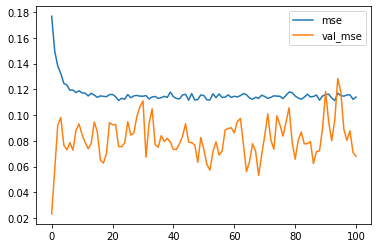

Prediction = 0.9809965491294861
Last corr = 0.91814
pred_col_name nrz_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.188129186630249  minutes


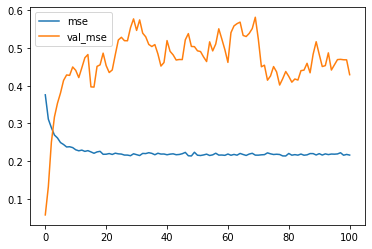

Prediction = 0.5878644585609436
Last corr = 0.846837
pred_col_name boch_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.2936402479807536  minutes


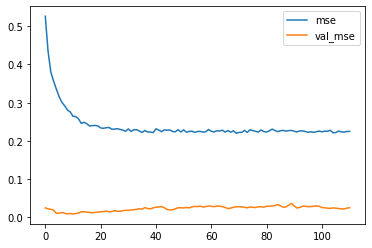

Prediction = 0.6530894041061401
Last corr = 0.636295
pred_col_name jpm_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3171639839808145  minutes


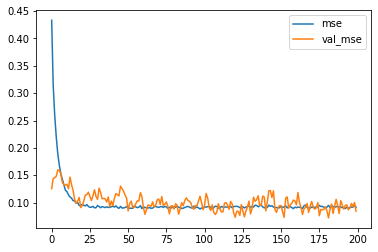

Prediction = 0.618987500667572
Last corr = 0.980518
pred_col_name hiw_pbj_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2094862341880799  minutes


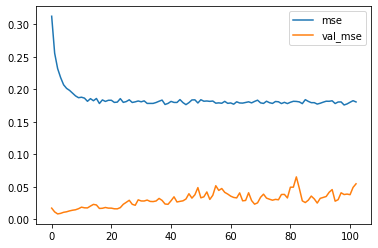

Prediction = 0.7740411162376404
Last corr = 0.777247
pred_col_name wfc_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
1.360575266679128  minutes


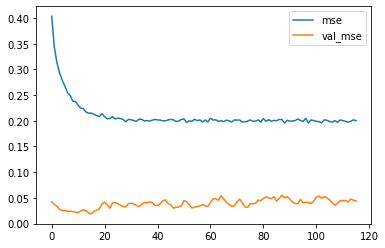

Prediction = 0.7815946936607361
Last corr = 0.859907
pred_col_name pacw_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
1.2539347688357034  minutes


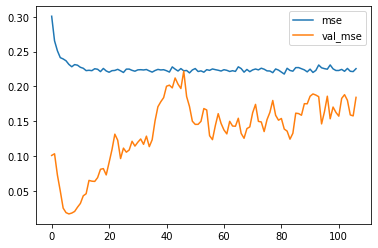

Prediction = 0.20549234747886658
Last corr = 0.455734
pred_col_name dlr_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1879095315933228  minutes


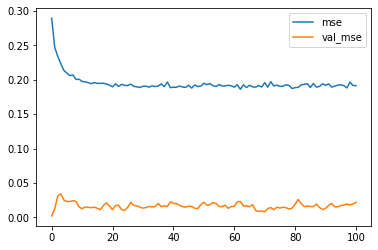

Prediction = 0.43877482414245605
Last corr = 0.415841
pred_col_name wal_jpm_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.296174617608388  minutes


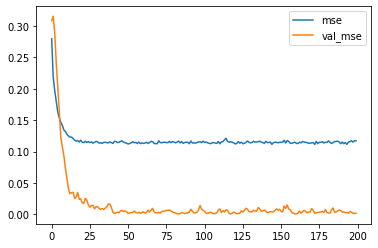

Prediction = 0.9822916984558105
Last corr = 0.992256
pred_col_name mtb_ewbc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.1969330469767252  minutes


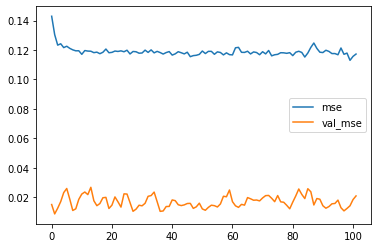

Prediction = 0.9793485403060913
Last corr = 0.940917
pred_col_name wfc_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2266284982363382  minutes


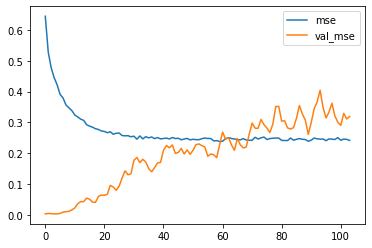

Prediction = 0.79475337266922
Last corr = 0.882801
pred_col_name fitb_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1837804675102235  minutes


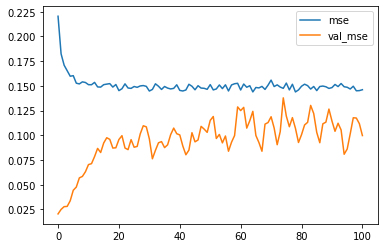

Prediction = 0.8822987079620361
Last corr = 0.964956
pred_col_name ubfo_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1846897840499877  minutes


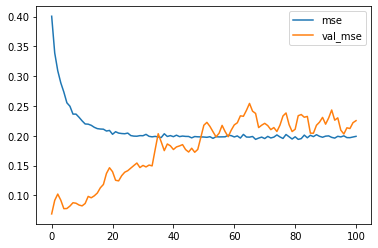

Prediction = 0.5782420039176941
Last corr = 0.903394
pred_col_name dre_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1879876891771952  minutes


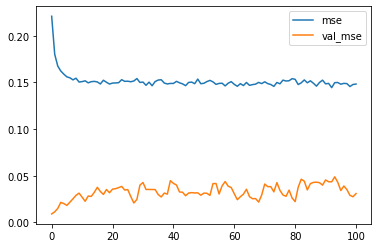

Prediction = 0.6526488065719604
Last corr = 0.734761
pred_col_name ubfo_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1967210570971172  minutes


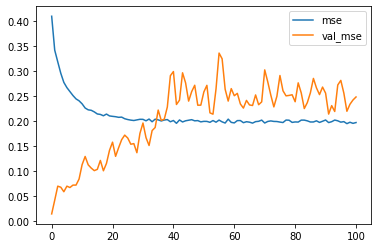

Prediction = 0.6219930052757263
Last corr = 0.813414
pred_col_name bsrr_dlr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00185: early stopping
2.121570650736491  minutes


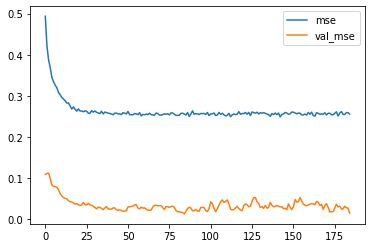

Prediction = 0.20426268875598907
Last corr = 0.411364
pred_col_name pfbc_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3185704191525778  minutes


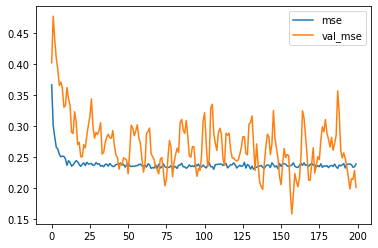

Prediction = 0.4349539875984192
Last corr = 0.915406
pred_col_name pfbc_hope_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3035285671552024  minutes


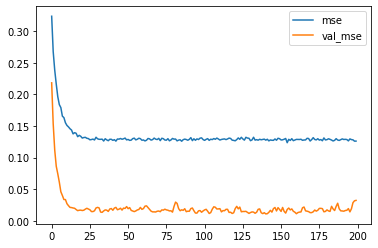

Prediction = 1.132491946220398
Last corr = 0.998079
pred_col_name frc_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
1.3075191617012023  minutes


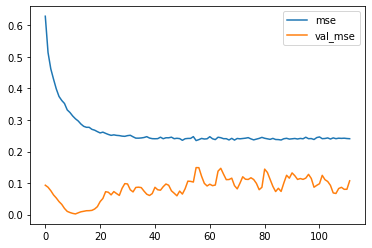

Prediction = 0.8480988144874573
Last corr = 0.868639
pred_col_name key_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.2987048665682477  minutes


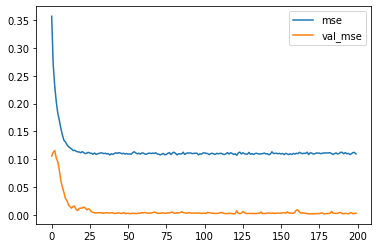

Prediction = 0.956657886505127
Last corr = 0.99682
pred_col_name jpm_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
1.308896819750468  minutes


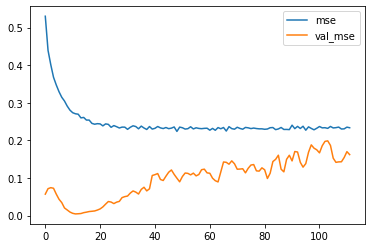

Prediction = 0.7754865288734436
Last corr = 0.853742
pred_col_name caty_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
1.9760973652203877  minutes


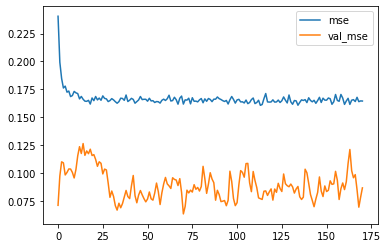

Prediction = 0.7075986266136169
Last corr = 0.967859
pred_col_name cma_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2007943352063497  minutes


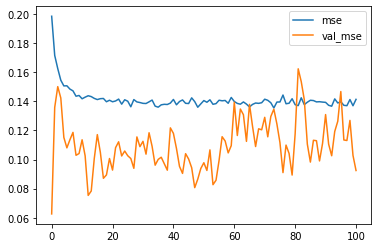

Prediction = 0.6929810047149658
Last corr = 0.929742
pred_col_name bku_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.2837101181348165  minutes


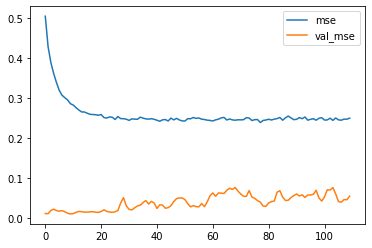

Prediction = 0.8454224467277527
Last corr = 0.830446
pred_col_name spy_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.2808204650878907  minutes


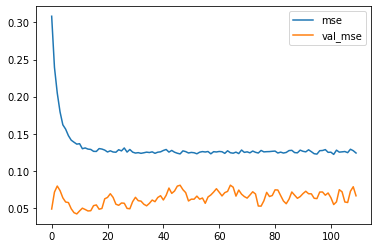

Prediction = 0.6718207597732544
Last corr = 0.84567
pred_col_name ubfo_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2240483164787292  minutes


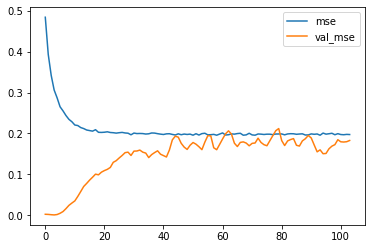

Prediction = 0.5330755114555359
Last corr = 0.56707
pred_col_name qqq_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2383057872454326  minutes


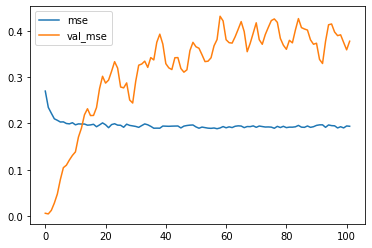

Prediction = 0.28328391909599304
Last corr = 0.383663
pred_col_name fsbw_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2194205482800802  minutes


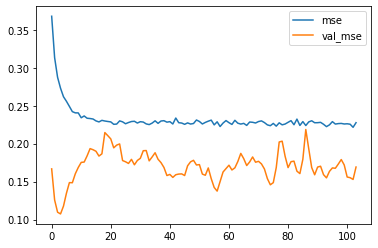

Prediction = 0.4628155827522278
Last corr = 0.729174
pred_col_name hasi_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2176124493281046  minutes


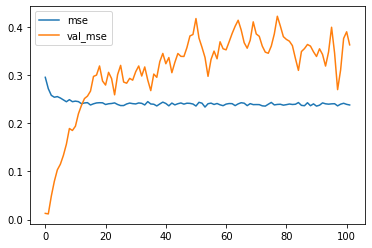

Prediction = 0.554633617401123
Last corr = 0.3934
pred_col_name spy_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1847696344057719  minutes


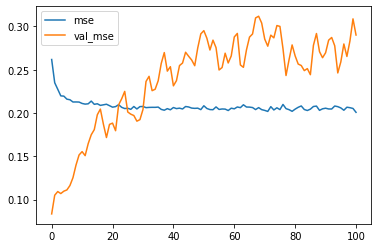

Prediction = 0.47750645875930786
Last corr = 0.755275
pred_col_name c_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2082115332285563  minutes


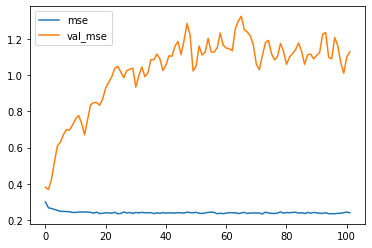

Prediction = 0.2565078139305115
Last corr = 0.941103
pred_col_name cvcy_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3093369801839194  minutes


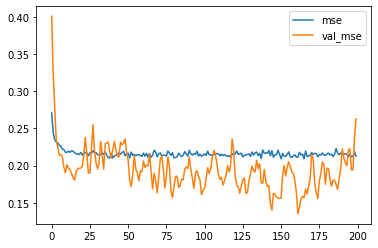

Prediction = 0.589036762714386
Last corr = 0.921871
pred_col_name cvbf_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.2477423826853433  minutes


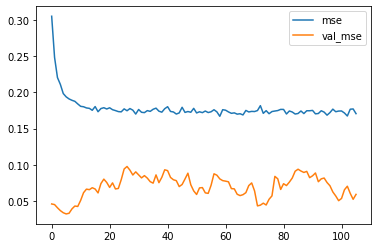

Prediction = 0.49352699518203735
Last corr = 0.286698
pred_col_name c_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
1.9085241516431173  minutes


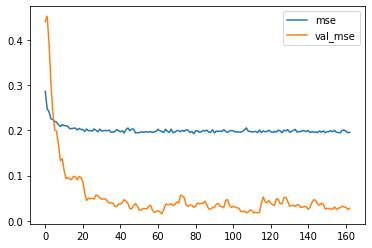

Prediction = 0.657209038734436
Last corr = 0.766498
pred_col_name fsbw_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
1.5125005006790162  minutes


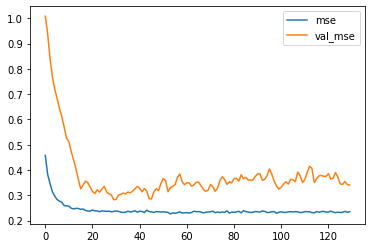

Prediction = 0.39912015199661255
Last corr = -0.26192
pred_col_name pfbc_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3059845328330995  minutes


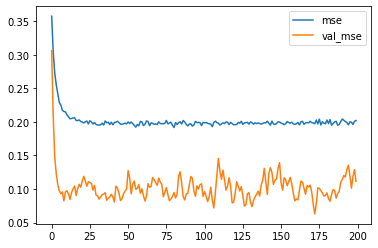

Prediction = 0.6122081279754639
Last corr = 0.850139
pred_col_name vfh_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2225960532824198  minutes


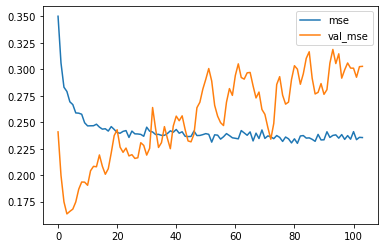

Prediction = 0.5672273635864258
Last corr = 0.874958
pred_col_name fitb_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00175: early stopping
2.009922750790914  minutes


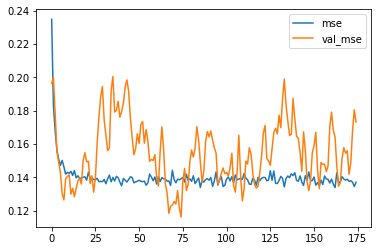

Prediction = 0.6582076549530029
Last corr = 0.934771
pred_col_name ubfo_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
1.3664020895957947  minutes


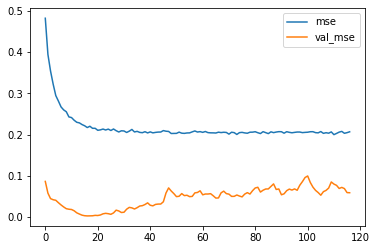

Prediction = 0.24238023161888123
Last corr = 0.212584
pred_col_name cwbc_key_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.2999810496966044  minutes


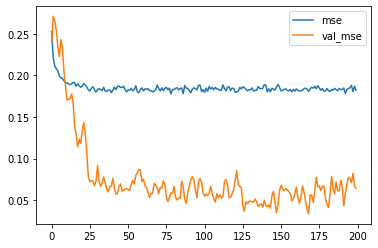

Prediction = 0.40956389904022217
Last corr = 0.568046
pred_col_name spy_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
1.576376219590505  minutes


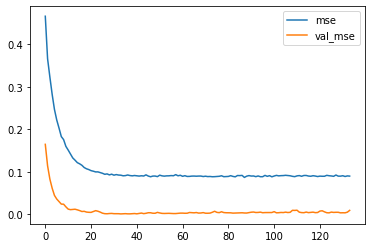

Prediction = 0.8676784038543701
Last corr = 0.848975
pred_col_name qqq_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.299879535039266  minutes


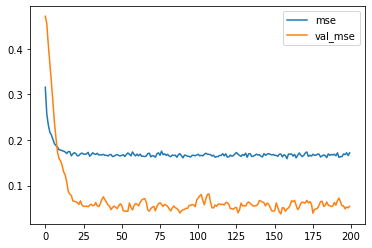

Prediction = 0.3640901446342468
Last corr = 0.189366
pred_col_name umpq_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.375085349877675  minutes


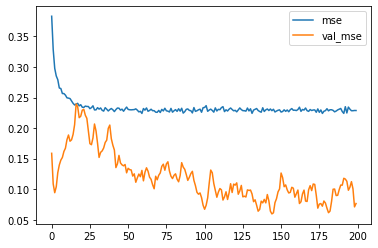

Prediction = -0.019854910671710968
Last corr = -0.256911
pred_col_name vfh_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.320748817920685  minutes


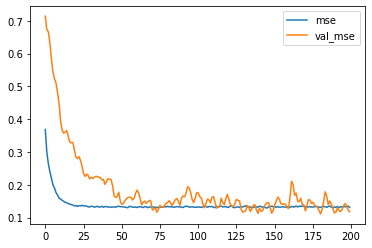

Prediction = 0.6188082098960876
Last corr = 0.934488
pred_col_name vti_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
1.4114251335461934  minutes


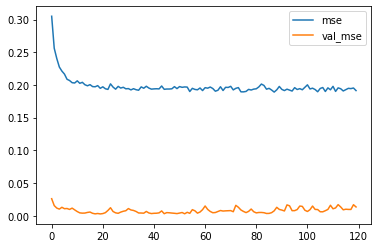

Prediction = 0.640357255935669
Last corr = 0.695311
pred_col_name ewbc_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
1.6121858517328898  minutes


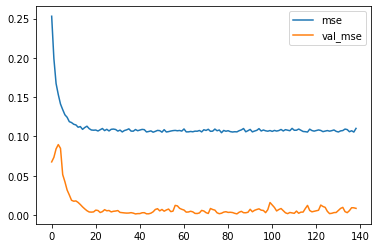

Prediction = 0.8929543495178223
Last corr = 0.935533
pred_col_name key_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3130611499150593  minutes


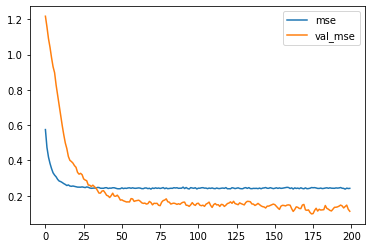

Prediction = 0.0070390719920396805
Last corr = -0.273085
pred_col_name mtb_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.292564948399862  minutes


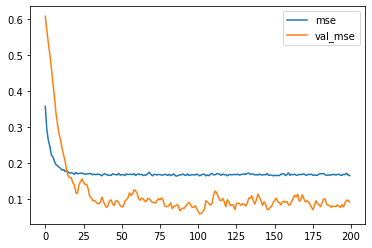

Prediction = 0.6674293875694275
Last corr = 0.898811
pred_col_name hasi_bsrr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1854238669077555  minutes


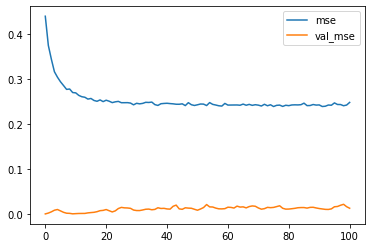

Prediction = 0.6798256635665894
Last corr = 0.620475
pred_col_name wfc_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.206820046901703  minutes


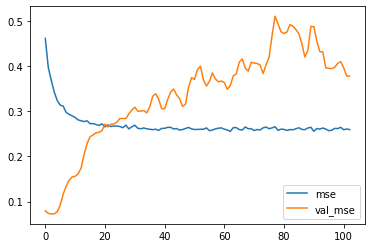

Prediction = 0.5336650609970093
Last corr = 0.852918
pred_col_name cwbc_hope_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2000621159871419  minutes


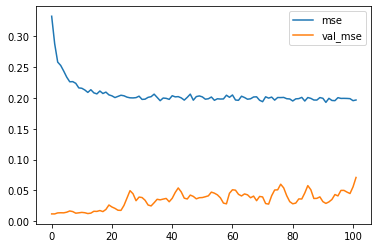

Prediction = 0.44409310817718506
Last corr = 0.524538
pred_col_name pfbc_cvbf_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
1.4360017657279969  minutes


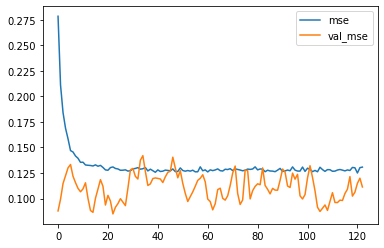

Prediction = 0.7288727760314941
Last corr = 0.963458
pred_col_name cwbc_gbci_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2343840678532918  minutes


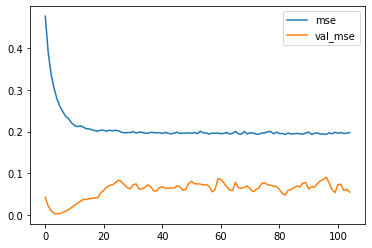

Prediction = 0.3832072615623474
Last corr = 0.461828
pred_col_name bjk_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2118775328000386  minutes


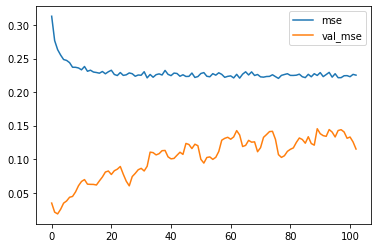

Prediction = 0.7293298244476318
Last corr = 0.736423
pred_col_name umpq_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping
1.6753861864407857  minutes


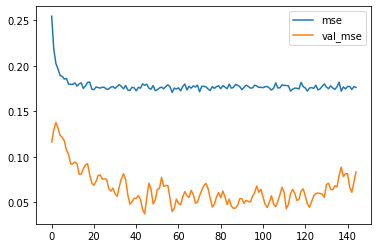

Prediction = 0.6520800590515137
Last corr = 0.899095
pred_col_name ntrs_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1813042998313903  minutes


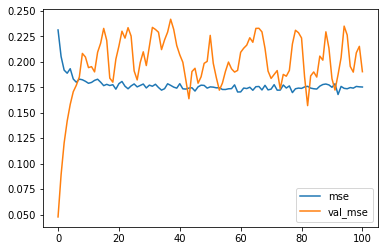

Prediction = 0.7387240529060364
Last corr = 0.984378
pred_col_name ewbc_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.3040685335795084  minutes


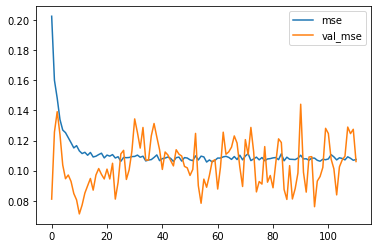

Prediction = 0.6259695291519165
Last corr = 0.845524
pred_col_name umpq_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.2393674333890279  minutes


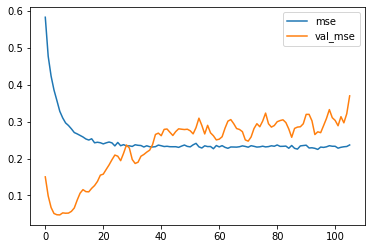

Prediction = 0.8493034839630127
Last corr = 0.967538
pred_col_name fsbw_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping
1.9484919985135396  minutes


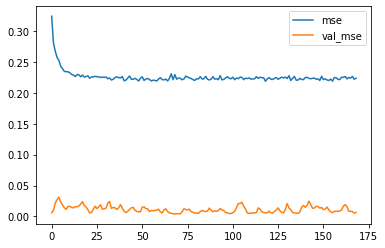

Prediction = 0.6454742550849915
Last corr = 0.717361
pred_col_name fsbw_gbci_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.1968331813812256  minutes


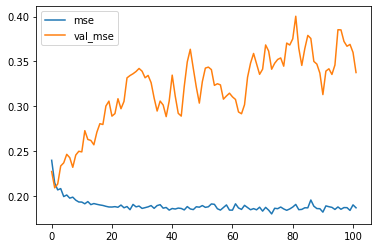

Prediction = 0.3465699255466461
Last corr = 0.78731
pred_col_name pfbc_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.2767887671788534  minutes


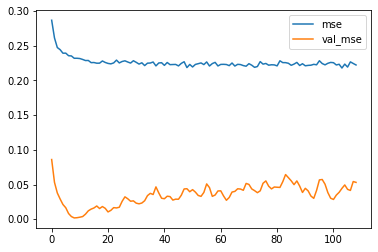

Prediction = 0.4190693199634552
Last corr = 0.389985
pred_col_name iwm_spy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.304366199175517  minutes


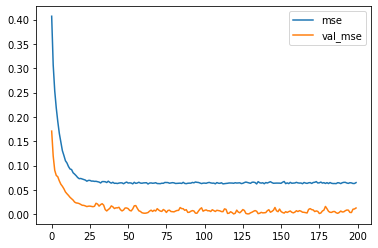

Prediction = 0.9931594133377075
Last corr = 0.869849
pred_col_name mtb_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
1.8945105830828348  minutes


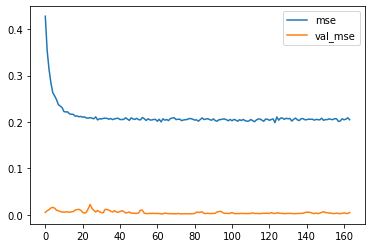

Prediction = 0.9797102212905884
Last corr = 0.963798
pred_col_name iwm_key_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1900981664657593  minutes


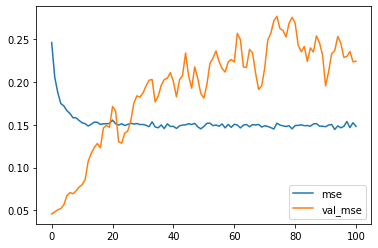

Prediction = 0.9816080927848816
Last corr = 0.994817
pred_col_name cvcy_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.289375615119934  minutes


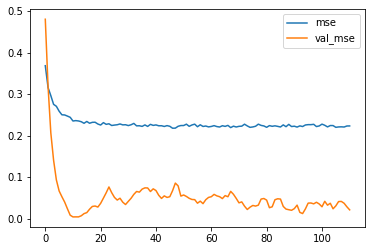

Prediction = 0.10643112659454346
Last corr = 0.144224
pred_col_name pacw_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3240193843841555  minutes


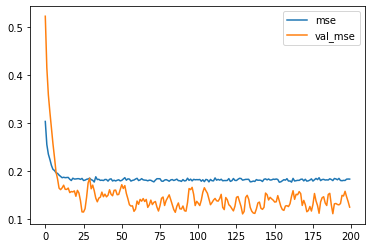

Prediction = 0.6869481205940247
Last corr = 0.951456
pred_col_name umpq_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00143: early stopping
1.7009271462758382  minutes


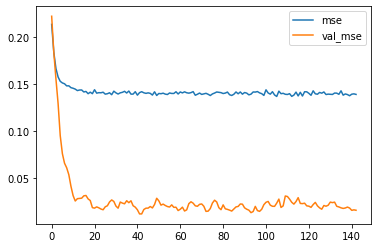

Prediction = 0.9430279731750488
Last corr = 0.979282
pred_col_name pacw_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.2320491711298625  minutes


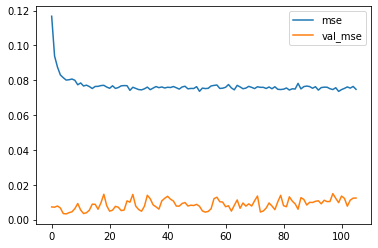

Prediction = 0.9180518984794617
Last corr = 0.959166
pred_col_name wfc_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1870958805084229  minutes


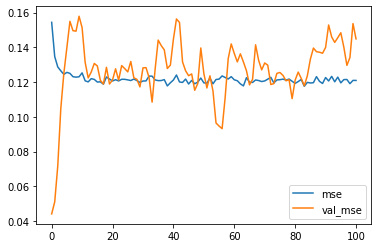

Prediction = 0.7233905792236328
Last corr = 0.998032
pred_col_name umpq_bsrr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
1.396855632464091  minutes


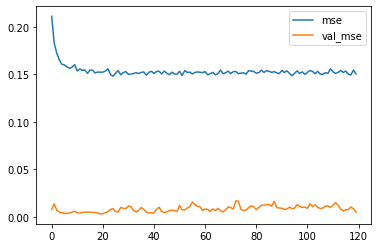

Prediction = 0.9517787098884583
Last corr = 0.89652
pred_col_name cvcy_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1936051368713378  minutes


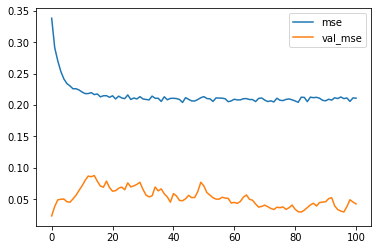

Prediction = 0.8261193633079529
Last corr = 0.939648
pred_col_name umpq_xrt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00165: early stopping
1.906635582447052  minutes


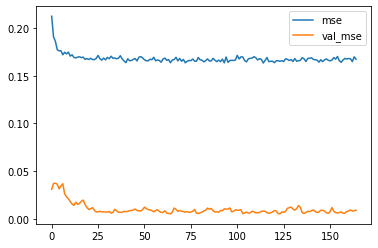

Prediction = 0.9588229656219482
Last corr = 0.915284
pred_col_name bac_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1846652507781983  minutes


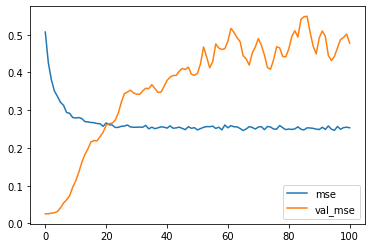

Prediction = 0.7247980833053589
Last corr = 0.811852
pred_col_name pfbc_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
2.1294991811116537  minutes


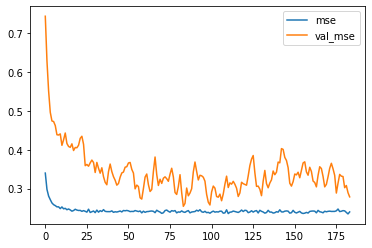

Prediction = 0.40582966804504395
Last corr = -0.166189
pred_col_name boch_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping
1.4089767336845398  minutes


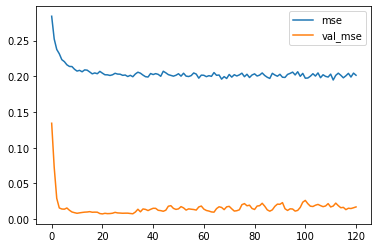

Prediction = 0.7554448246955872
Last corr = 0.754185
pred_col_name wfc_spy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.1949537992477417  minutes


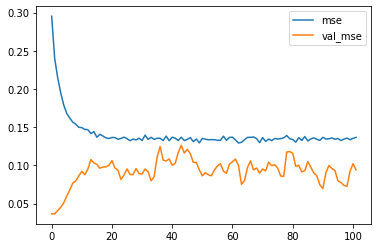

Prediction = 1.087153673171997
Last corr = 0.912301
pred_col_name caty_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1914243181546529  minutes


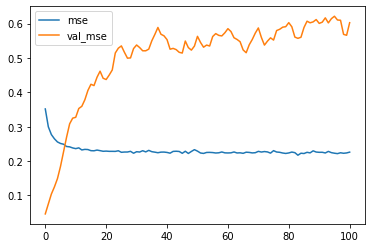

Prediction = 0.8149929046630859
Last corr = 0.847512
pred_col_name jpm_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3083774487177533  minutes


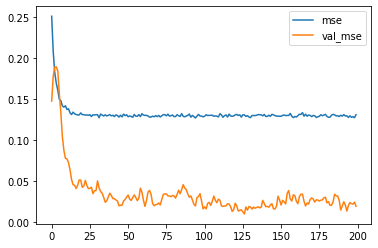

Prediction = 0.8890674114227295
Last corr = 0.988767
pred_col_name iwm_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1868807315826415  minutes


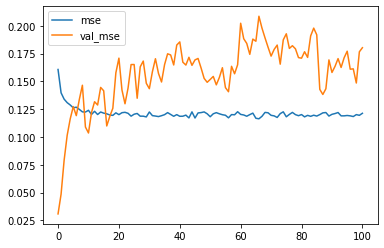

Prediction = 0.9081113934516907
Last corr = 0.978727
pred_col_name bmrc_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1840685486793519  minutes


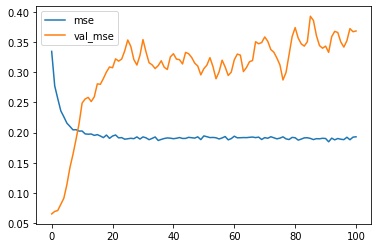

Prediction = 0.857427179813385
Last corr = 0.960774
pred_col_name ubfo_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1942258675893147  minutes


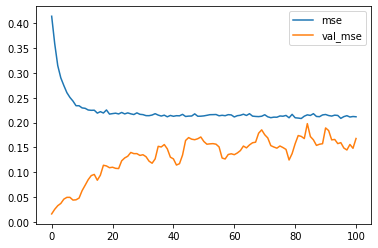

Prediction = 0.7020230889320374
Last corr = 0.801874
pred_col_name ntrs_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.2802297314008078  minutes


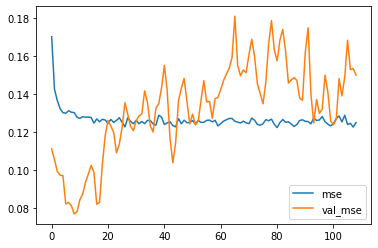

Prediction = 0.7481322884559631
Last corr = 0.979081
pred_col_name ewbc_xrt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2241148869196574  minutes


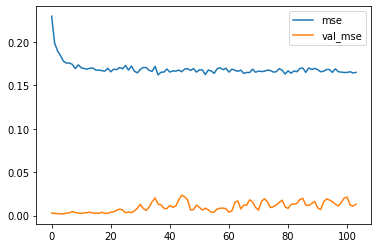

Prediction = 0.8516548871994019
Last corr = 0.822116
pred_col_name colb_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3428199648857118  minutes


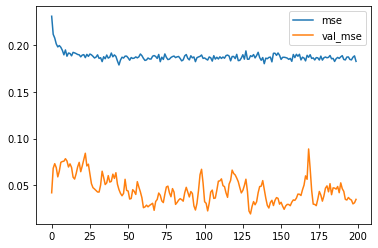

Prediction = 0.8470005393028259
Last corr = 0.934163
pred_col_name irm_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2283520340919494  minutes


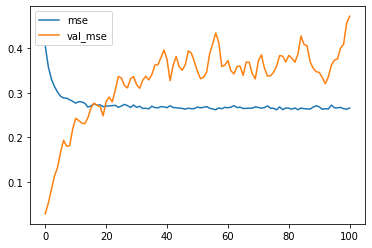

Prediction = 0.7082528471946716
Last corr = 0.832332
pred_col_name wal_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1914642175038657  minutes


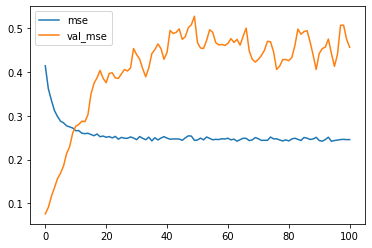

Prediction = 0.6425294876098633
Last corr = 0.867696
pred_col_name irm_key_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.19166126648585  minutes


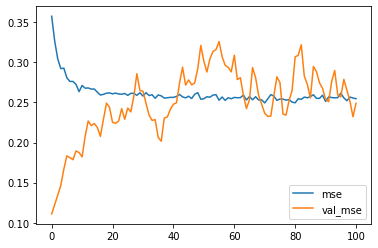

Prediction = 0.5613874197006226
Last corr = 0.882981
pred_col_name dia_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2269599159558615  minutes


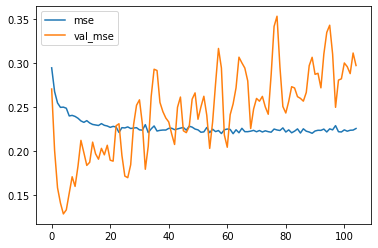

Prediction = 0.3783135414123535
Last corr = -0.009531
pred_col_name pacw_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.186746029059092  minutes


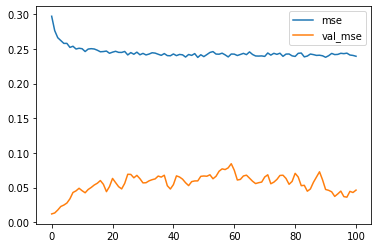

Prediction = 0.27083665132522583
Last corr = 0.420015
pred_col_name mtb_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
1.445944086710612  minutes


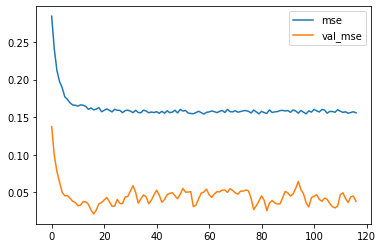

Prediction = 0.8487176895141602
Last corr = 0.907274
pred_col_name vfh_sui_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.1902643163998923  minutes


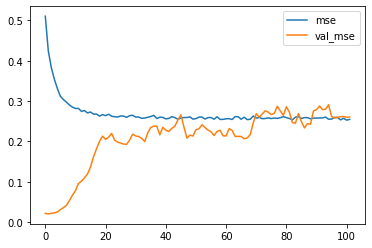

Prediction = 0.7648196816444397
Last corr = 0.878852
pred_col_name pbj_c_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1912400841712951  minutes


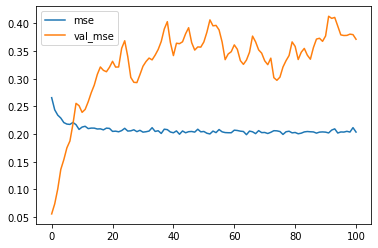

Prediction = 0.6207827925682068
Last corr = 0.828059
pred_col_name wfc_dlr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.195188013712565  minutes


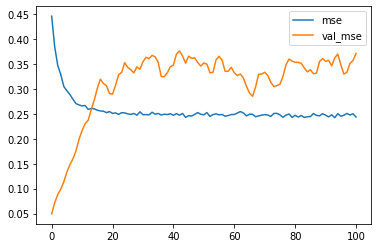

Prediction = 0.6023205518722534
Last corr = 0.772034
pred_col_name fsbw_key_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
1.3442319830258687  minutes


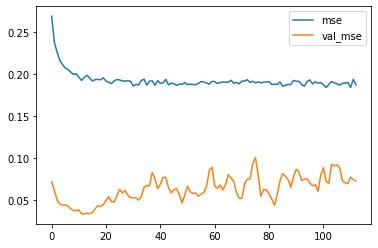

Prediction = 0.7454226613044739
Last corr = 0.871736
pred_col_name dre_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1890422821044921  minutes


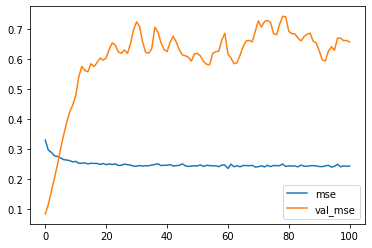

Prediction = 0.7822862863540649
Last corr = 0.911404
pred_col_name cvbf_fitb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2288898348808288  minutes


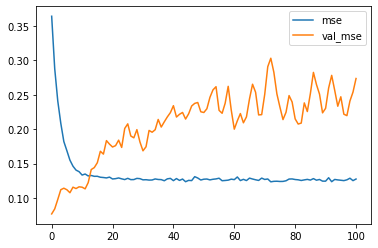

Prediction = 0.811208963394165
Last corr = 0.989057
pred_col_name ewbc_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.210844381650289  minutes


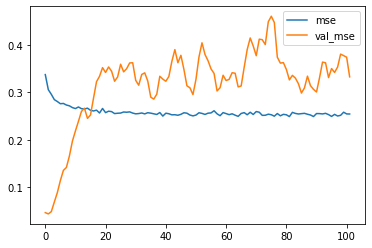

Prediction = 0.9617094993591309
Last corr = 0.963729
pred_col_name mtb_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1820817192395527  minutes


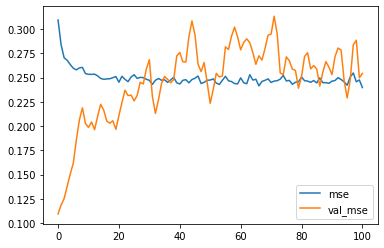

Prediction = 0.580370306968689
Last corr = 0.864197
pred_col_name fitb_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1895322998364766  minutes


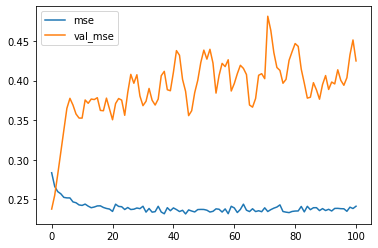

Prediction = 0.3829822540283203
Last corr = 0.901529
pred_col_name mtb_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.351777132352193  minutes


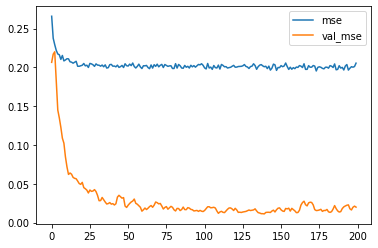

Prediction = 0.8088325262069702
Last corr = 0.779072
pred_col_name fitb_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1963768482208252  minutes


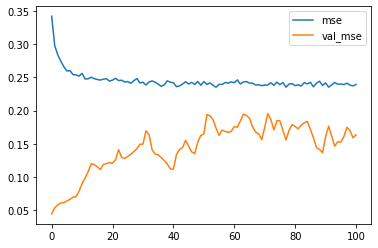

Prediction = 0.6558653712272644
Last corr = 0.848548
pred_col_name fsbw_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2167003671328227  minutes


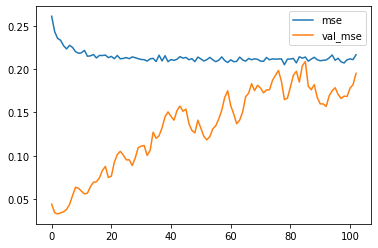

Prediction = 0.9265369176864624
Last corr = 0.817475
pred_col_name c_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2056973616282145  minutes


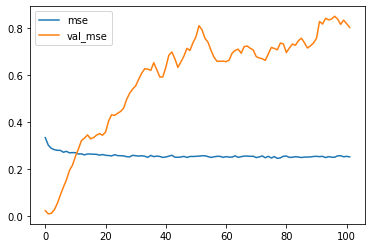

Prediction = 0.6756312847137451
Last corr = 0.591531
pred_col_name sui_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.316240680217743  minutes


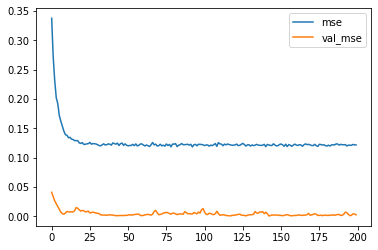

Prediction = 0.8810632824897766
Last corr = 0.955807
pred_col_name nrz_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1841956655184427  minutes


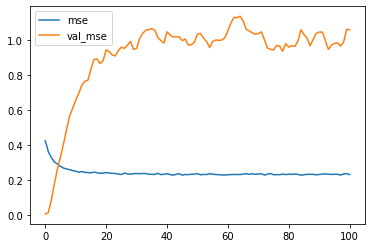

Prediction = 0.8570392727851868
Last corr = 0.779587
pred_col_name dre_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1927432974179586  minutes


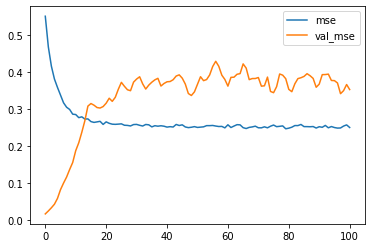

Prediction = 0.7497722506523132
Last corr = 0.860376
pred_col_name fitb_wfc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2120227813720703  minutes


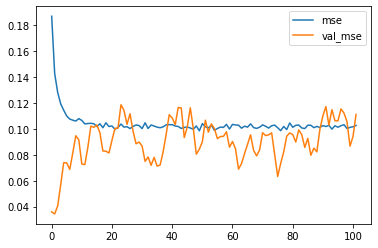

Prediction = 0.919418215751648
Last corr = 0.994305
pred_col_name qqq_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
1.5125753005345663  minutes


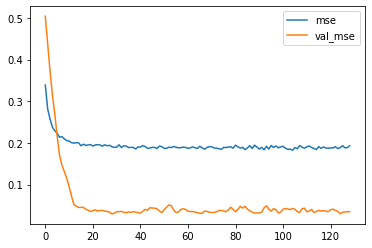

Prediction = 0.24240340292453766
Last corr = 0.111511
pred_col_name sivb_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
1.4616955161094665  minutes


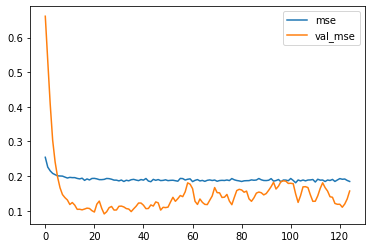

Prediction = 0.7902888655662537
Last corr = 0.945769
pred_col_name boch_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
1.5956277132034302  minutes


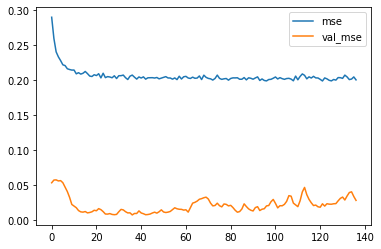

Prediction = 0.7201361656188965
Last corr = 0.800762
pred_col_name bku_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
1.3999521652857463  minutes


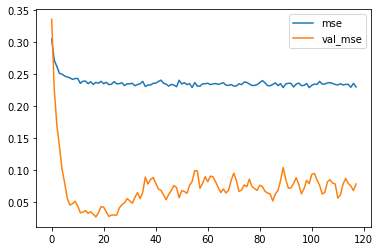

Prediction = 0.15985776484012604
Last corr = -0.013849
pred_col_name wal_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00160: early stopping
1.8684460997581482  minutes


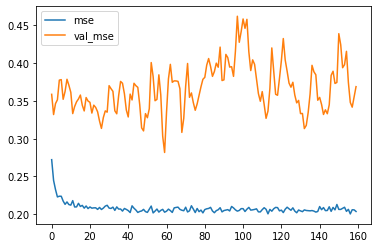

Prediction = 0.49529364705085754
Last corr = 0.897236
pred_col_name iwm_ntrs_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
1.8120917002360026  minutes


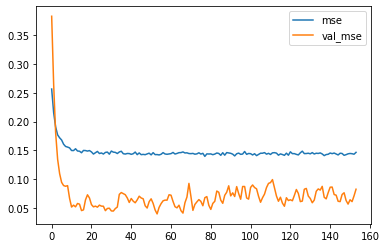

Prediction = 0.8247259855270386
Last corr = 0.986927
pred_col_name mtb_bsrr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00197: early stopping
2.3043023546536765  minutes


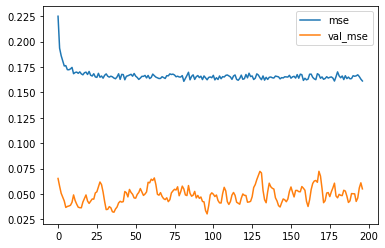

Prediction = 0.8575710654258728
Last corr = 0.884507
pred_col_name pacw_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1945098837216694  minutes


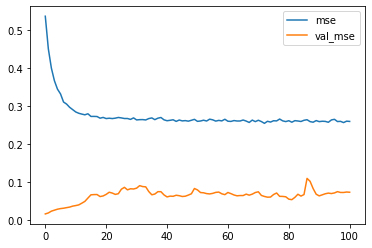

Prediction = 0.8897944092750549
Last corr = 0.799727
pred_col_name jpm_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3035007158915204  minutes


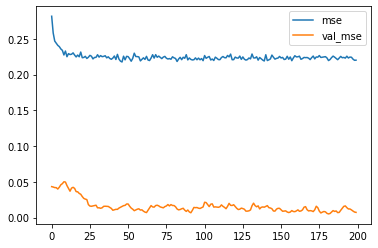

Prediction = 0.8233349323272705
Last corr = 0.812863
pred_col_name hasi_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.2836393356323241  minutes


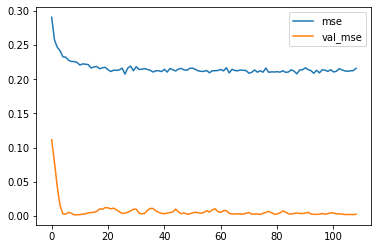

Prediction = 0.34393659234046936
Last corr = 0.291672
pred_col_name fsbw_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1971156477928162  minutes


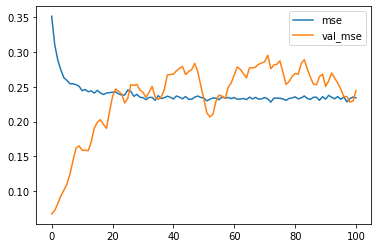

Prediction = 0.5156465172767639
Last corr = 0.70115
pred_col_name wal_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.250247565905253  minutes


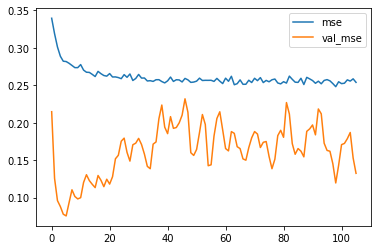

Prediction = 0.6915456652641296
Last corr = 0.864781
pred_col_name wabc_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1920898675918579  minutes


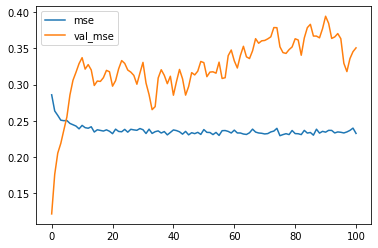

Prediction = 0.525173008441925
Last corr = 0.743489
pred_col_name key_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping
1.418418248494466  minutes


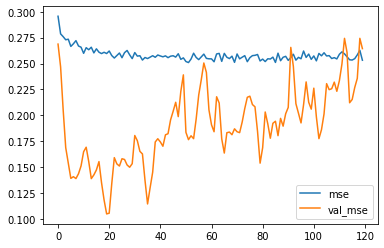

Prediction = 0.6515355110168457
Last corr = 0.922516
pred_col_name fitb_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
1.2816996971766155  minutes


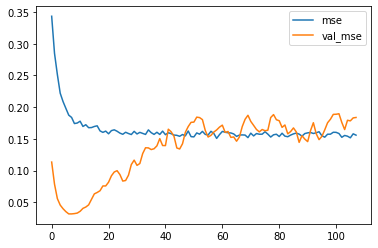

Prediction = 0.2598341703414917
Last corr = 0.179547
pred_col_name qqq_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2308546503384907  minutes


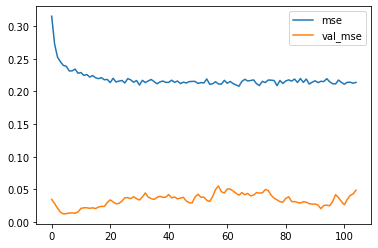

Prediction = 0.16295967996120453
Last corr = 0.231742
pred_col_name fitb_gbci_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.30521076520284  minutes


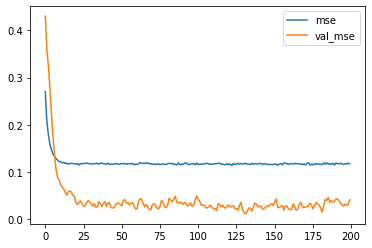

Prediction = 0.8723270297050476
Last corr = 0.972218
pred_col_name bmrc_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
2.0059419671694436  minutes


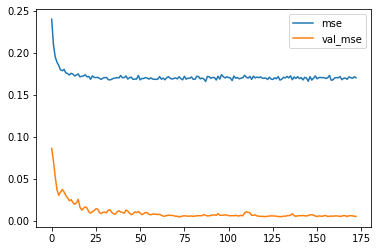

Prediction = 1.0625300407409668
Last corr = 0.980699
pred_col_name key_sui_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2143980820973714  minutes


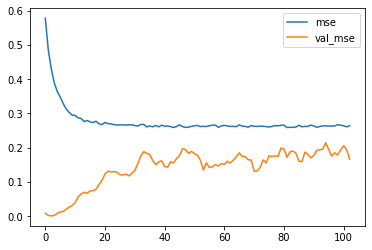

Prediction = 0.8840257525444031
Last corr = 0.897582
pred_col_name c_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
1.575030767917633  minutes


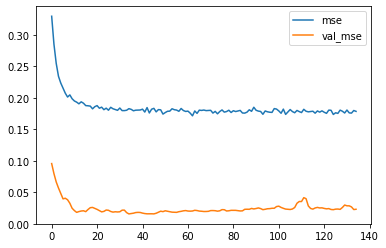

Prediction = 0.4869910478591919
Last corr = 0.676602
pred_col_name hope_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2506670991579691  minutes


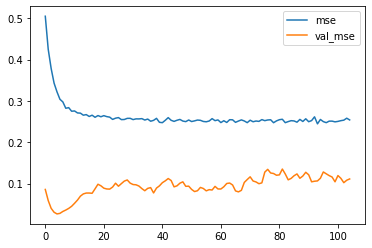

Prediction = 0.8316758275032043
Last corr = 0.946084
pred_col_name ntrs_c_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2078191002209981  minutes


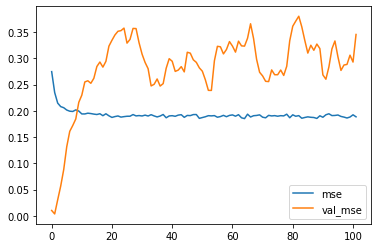

Prediction = 0.6763841509819031
Last corr = 0.752155
pred_col_name ntrs_cma_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
1.3481477697690327  minutes


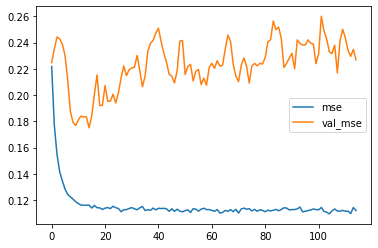

Prediction = 0.5824381113052368
Last corr = 0.997037
pred_col_name bsrr_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2361488103866578  minutes


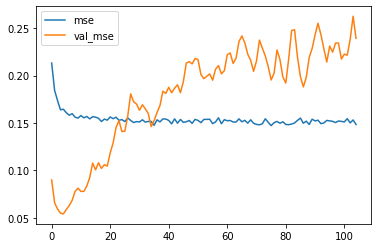

Prediction = 0.7264288663864136
Last corr = 0.891873
pred_col_name wal_vfh_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
1.368543303012848  minutes


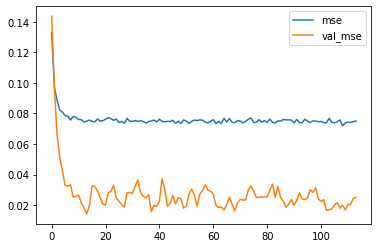

Prediction = 0.9705336689949036
Last corr = 0.997243
pred_col_name cwbc_spy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.255298900604248  minutes


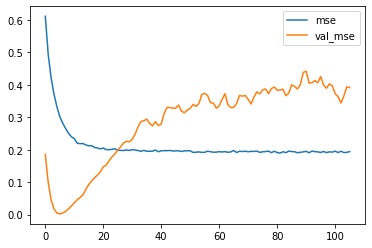

Prediction = 0.4529840350151062
Last corr = 0.446313
pred_col_name ntrs_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2374783833821614  minutes


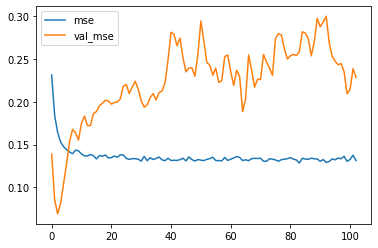

Prediction = 0.5957168936729431
Last corr = 0.924065
pred_col_name jpm_pacw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
1.470723068714142  minutes


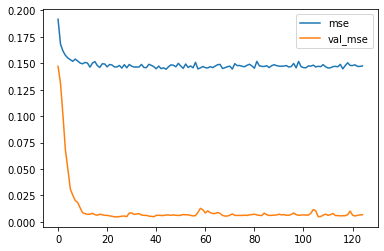

Prediction = 0.9473329186439514
Last corr = 0.939804
pred_col_name vti_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.243844215075175  minutes


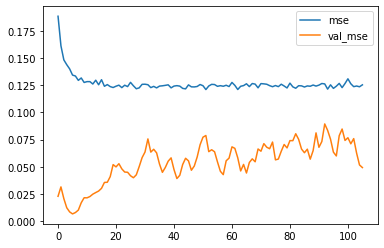

Prediction = 0.8975305557250977
Last corr = 0.920245
pred_col_name usb_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.2535888155301411  minutes


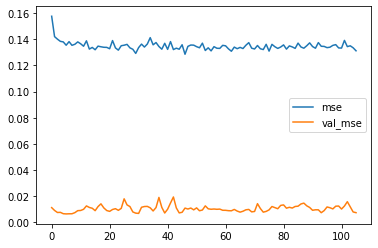

Prediction = 0.8870397210121155
Last corr = 0.955102
pred_col_name colb_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
1.6228680650393168  minutes


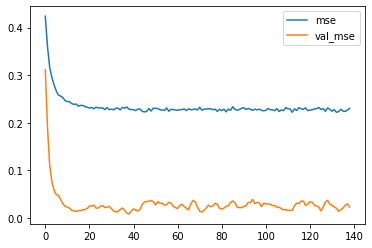

Prediction = 0.25162217020988464
Last corr = 0.245758
pred_col_name irm_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.270971131324768  minutes


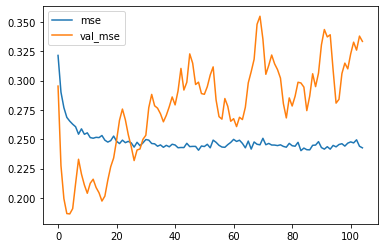

Prediction = 0.479911208152771
Last corr = 0.971537
pred_col_name pej_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.2910611470540365  minutes


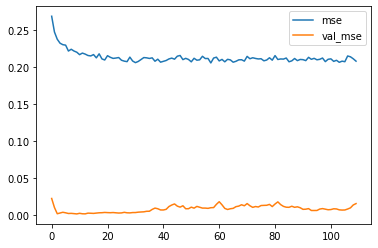

Prediction = 0.8001648187637329
Last corr = 0.7367
pred_col_name mtb_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2025203148523966  minutes


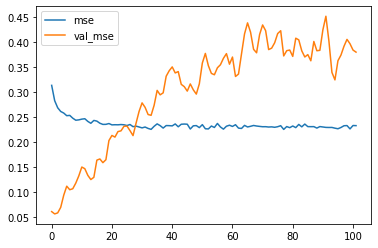

Prediction = 0.7858541011810303
Last corr = 0.925126
pred_col_name wfc_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
2.2345507661501567  minutes


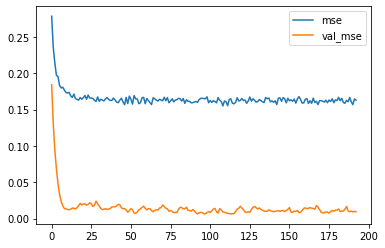

Prediction = 0.04237370938062668
Last corr = 0.181589
pred_col_name sui_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
1.6739272356033326  minutes


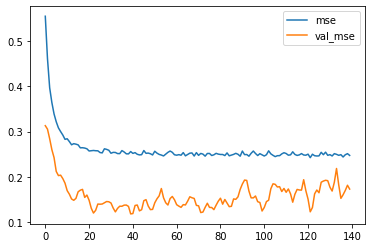

Prediction = 0.5929160714149475
Last corr = 0.829656
pred_col_name spy_hope_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
2.182834831873576  minutes


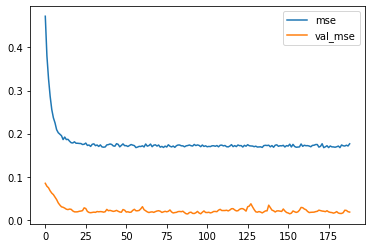

Prediction = 0.7985374331474304
Last corr = 0.781612
pred_col_name wabc_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1994661172231038  minutes


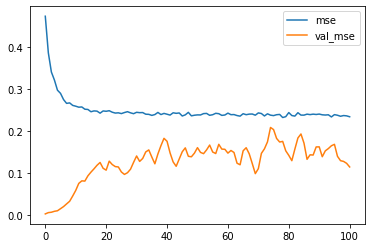

Prediction = 0.7192075848579407
Last corr = 0.7472
pred_col_name wabc_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
1.3799715638160706  minutes


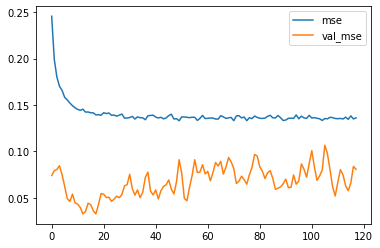

Prediction = 0.8394370675086975
Last corr = 0.940916
pred_col_name pfbc_iwm_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2020663499832154  minutes


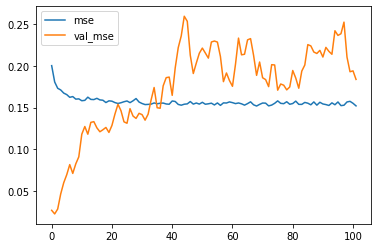

Prediction = 0.9514354467391968
Last corr = 0.976595
pred_col_name cvcy_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00150: early stopping
1.7631207505861919  minutes


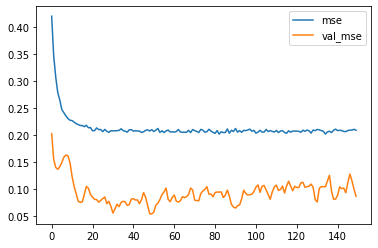

Prediction = 0.5230190753936768
Last corr = 0.340169
pred_col_name ntrs_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00137: early stopping
1.6004487832387289  minutes


Prediction = 0.27330517768859863
Last corr = 0.245808
pred_col_name iwm_fitb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
1.4895081679026285  minutes


Prediction = 0.9361439943313599
Last corr = 0.986079
pred_col_name ewbc_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2251031676928201  minutes


Prediction = 0.35165613889694214
Last corr = 0.430203
pred_col_name sui_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.314986534913381  minutes


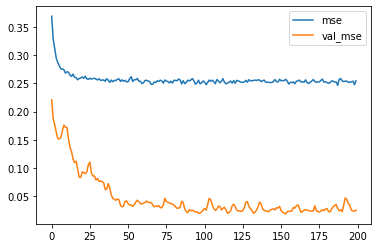

Prediction = 0.7764449715614319
Last corr = 0.855905
pred_col_name dre_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
1.4784446159998577  minutes


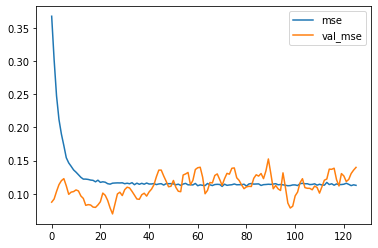

Prediction = 0.6762226819992065
Last corr = 0.970233
pred_col_name ubfo_pacw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.344128704071045  minutes


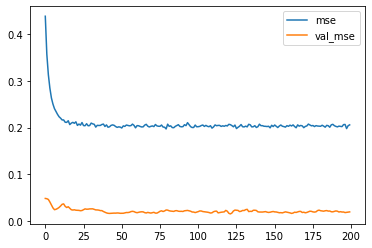

Prediction = 1.0399750471115112
Last corr = 0.910548
pred_col_name bjk_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3527974009513857  minutes


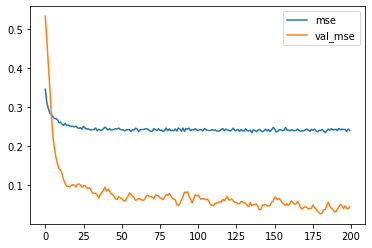

Prediction = 0.2897798418998718
Last corr = 0.041646
pred_col_name ewbc_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.309342034657796  minutes


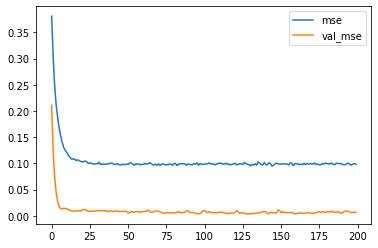

Prediction = 0.9030385613441467
Last corr = 0.826869
pred_col_name vno_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.20393309990565  minutes


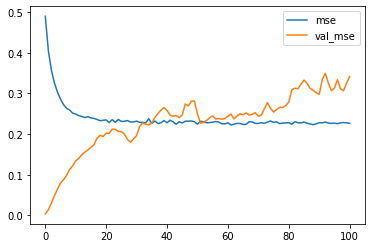

Prediction = 0.7912217378616333
Last corr = 0.809355
pred_col_name bku_xrt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
1.4706757505734762  minutes


Prediction = 1.002463698387146
Last corr = 0.962612
pred_col_name nrz_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1935081879297893  minutes


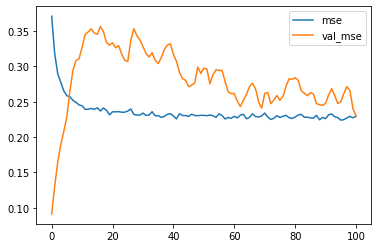

Prediction = 0.6842991709709167
Last corr = 0.904607
pred_col_name cma_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.3091803153355916  minutes


Prediction = 1.0561522245407104
Last corr = 0.954452
pred_col_name wal_sui_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2088862657546997  minutes


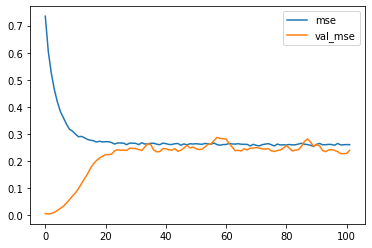

Prediction = 0.8958533406257629
Last corr = 0.84972
pred_col_name wfc_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
2.2463876644770306  minutes


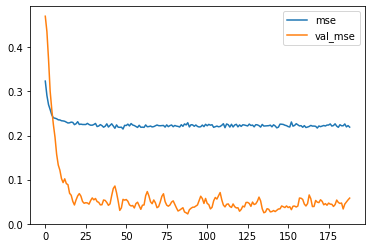

Prediction = 0.3248516321182251
Last corr = 0.193402
pred_col_name ewbc_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3101950844128925  minutes


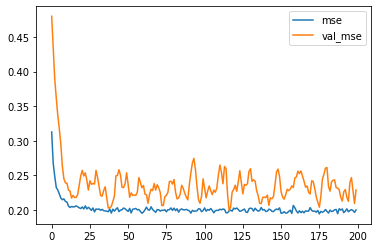

Prediction = 0.5764290690422058
Last corr = 0.860091
pred_col_name ntrs_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00159: early stopping
1.863093101978302  minutes


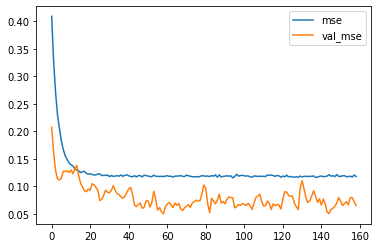

Prediction = 0.7965390682220459
Last corr = 0.986384
pred_col_name hasi_iwm_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1893439332644145  minutes


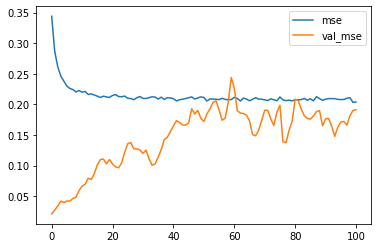

Prediction = 0.7940606474876404
Last corr = 0.598948
pred_col_name pbj_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1893048644065858  minutes


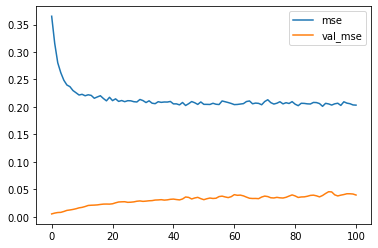

Prediction = 0.893413245677948
Last corr = 0.812567
pred_col_name pbj_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00154: early stopping
1.7967726310094199  minutes


Prediction = 0.10637456178665161
Last corr = -0.04122
pred_col_name umpq_irm_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
1.5791522185007731  minutes


Prediction = 0.3593466281890869
Last corr = 0.799967
pred_col_name wal_ewbc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00178: early stopping
2.08782445192337  minutes


Prediction = 0.8697589635848999
Last corr = 0.879092
pred_col_name hasi_spy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
1.3557951331138611  minutes


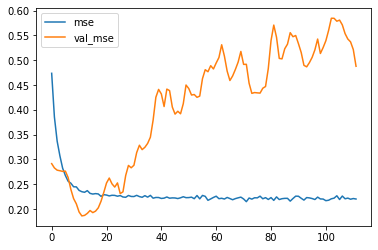

Prediction = 0.6144988536834717
Last corr = 0.23173
pred_col_name key_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
1.9515904545783997  minutes


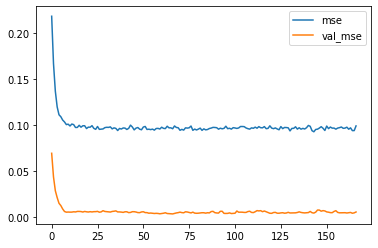

Prediction = 0.9936644434928894
Last corr = 0.960536
pred_col_name qqq_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping
1.3865524013837178  minutes


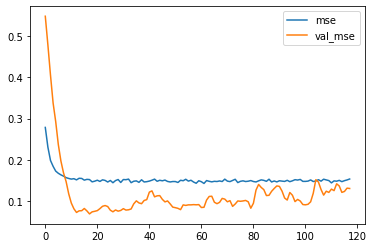

Prediction = 0.2994098961353302
Last corr = 0.132178
pred_col_name pfbc_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
1.2676246166229248  minutes


Prediction = 0.5398445725440979
Last corr = 0.732375
pred_col_name cvbf_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
1.7654762824376424  minutes


Prediction = 0.31302928924560547
Last corr = 0.860922
pred_col_name cvbf_spy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
1.2642771045366923  minutes


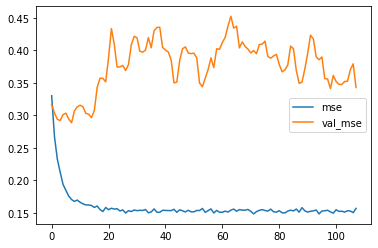

Prediction = 0.41715776920318604
Last corr = 0.935401
pred_col_name cvbf_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.350396382808685  minutes


Prediction = 0.7727558612823486
Last corr = 0.98086
pred_col_name caty_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.30586119890213  minutes


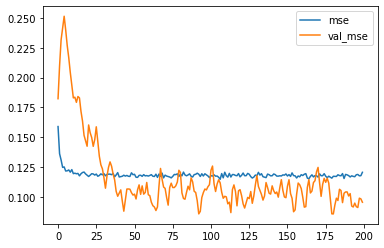

Prediction = 0.6326232552528381
Last corr = 0.985098
pred_col_name cvbf_gbci_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.30817670027415  minutes


Prediction = 0.7016372084617615
Last corr = 0.975722
pred_col_name fsbw_agnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.231058398882548  minutes


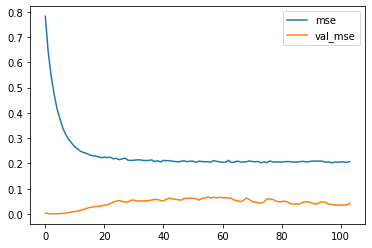

Prediction = 0.6043725609779358
Last corr = 0.616128
pred_col_name bsrr_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.343654179573059  minutes


Prediction = 0.43152496218681335
Last corr = -0.24816
pred_col_name fitb_usb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3261716842651365  minutes


Prediction = 0.9362549185752869
Last corr = 0.991651
pred_col_name ubfo_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2025641361872355  minutes


Prediction = 0.8297951221466064
Last corr = 0.849105
pred_col_name wfc_agnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00128: early stopping
1.5012762149175007  minutes


Prediction = 0.5048235654830933
Last corr = 0.324941
pred_col_name cpt_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
1.5085277994473776  minutes


Prediction = 0.6994600892066956
Last corr = 0.836839
pred_col_name ntrs_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.3091946840286255  minutes


Prediction = 0.669409990310669
Last corr = 0.891426
pred_col_name dlr_cvcy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1994306882222494  minutes


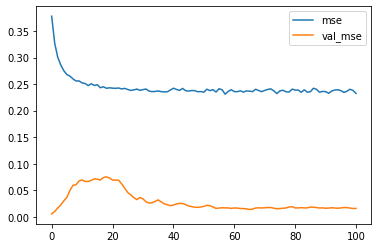

Prediction = 0.5422791838645935
Last corr = 0.587739
pred_col_name ewbc_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2126195669174193  minutes


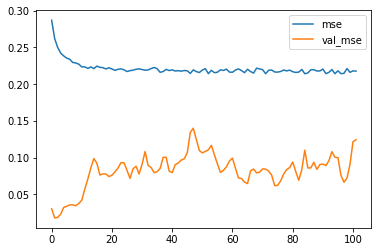

Prediction = 0.7755405902862549
Last corr = 0.885585
pred_col_name dre_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2050092538197836  minutes


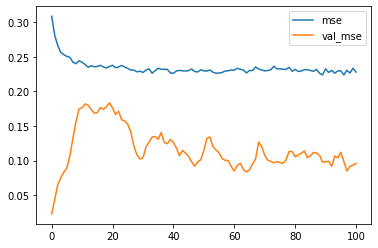

Prediction = 0.6724700331687927
Last corr = 0.723027
pred_col_name hasi_ewbc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2188884536425273  minutes


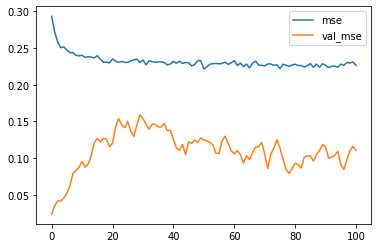

Prediction = 0.564063310623169
Last corr = 0.722227
pred_col_name cwbc_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2238267501195272  minutes


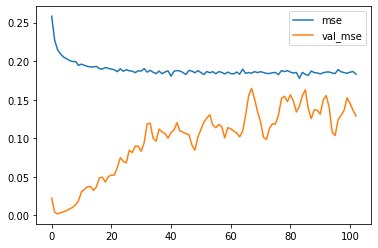

Prediction = 0.33631017804145813
Last corr = 0.372019
pred_col_name sui_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3226074973742166  minutes


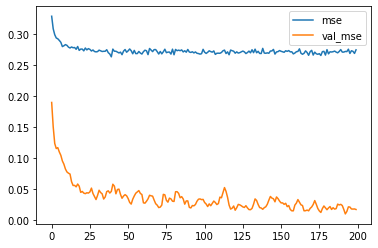

Prediction = 0.9294200539588928
Last corr = 0.867345
pred_col_name gbci_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.241798953215281  minutes


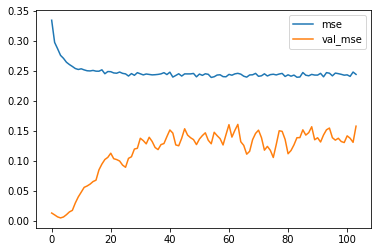

Prediction = 0.8281810879707336
Last corr = 0.72297
pred_col_name pfbc_cma_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
1.7422736883163452  minutes


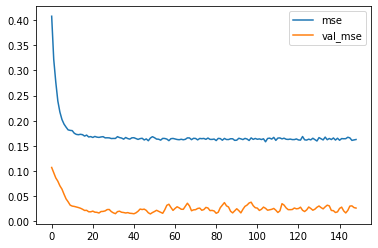

Prediction = 0.9353669285774231
Last corr = 0.985662
pred_col_name iwm_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.2627361377080282  minutes


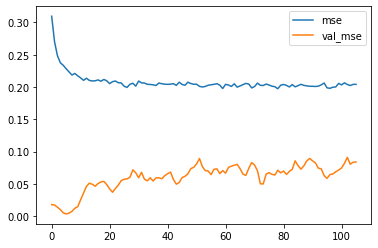

Prediction = 0.8007792830467224
Last corr = 0.791524
pred_col_name wal_qqq_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.2966808835665384  minutes


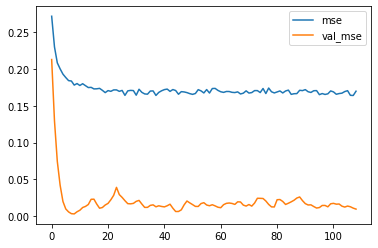

Prediction = 0.29683589935302734
Last corr = 0.251256
pred_col_name cvbf_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00112: early stopping
1.323568336168925  minutes


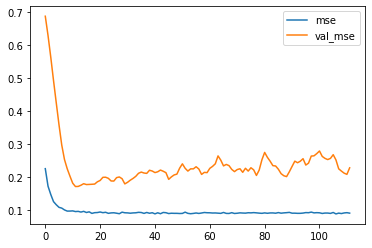

Prediction = 0.7333988547325134
Last corr = 0.987425
pred_col_name umpq_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00113: early stopping
1.335456665356954  minutes


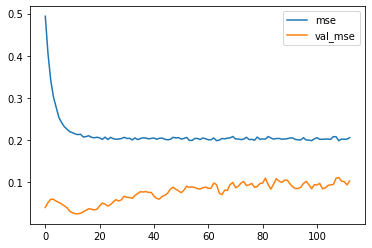

Prediction = 0.7958072423934937
Last corr = 0.82694
pred_col_name dlr_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1979909976323446  minutes


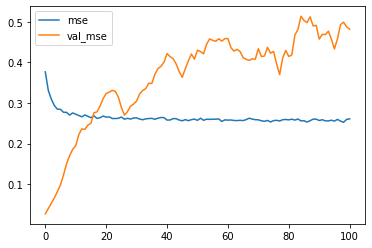

Prediction = 0.8849897980690002
Last corr = 0.854397
pred_col_name vfh_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
1.437956448396047  minutes


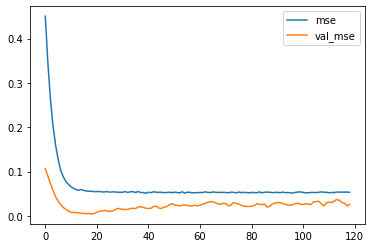

Prediction = 0.9349443316459656
Last corr = 0.982193
pred_col_name spy_c_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.203604765733083  minutes


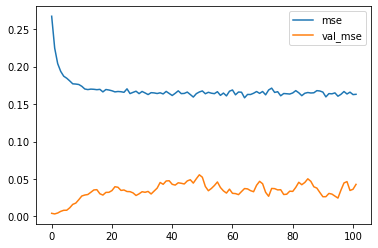

Prediction = 0.9255655407905579
Last corr = 0.90304
pred_col_name hiw_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3486719648043315  minutes


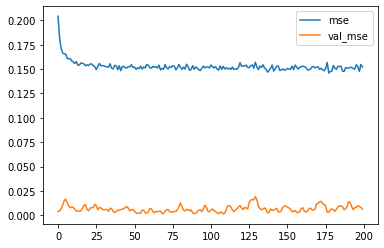

Prediction = 0.8038820624351501
Last corr = 0.906663
pred_col_name hope_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.3001736521720886  minutes


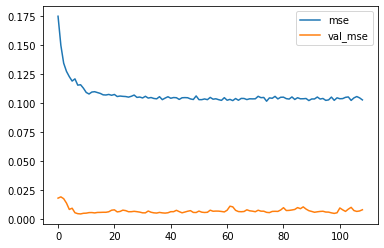

Prediction = 0.9252280592918396
Last corr = 0.890106
pred_col_name irm_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2377483367919921  minutes


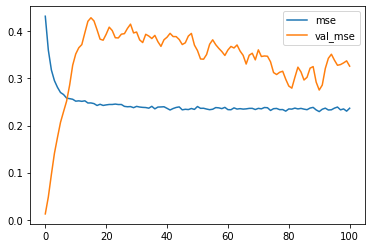

Prediction = 0.7078932523727417
Last corr = 0.811445
pred_col_name ubfo_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1999531706174216  minutes


Prediction = 0.7131699323654175
Last corr = 0.85947
pred_col_name ntrs_wabc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.206135869026184  minutes


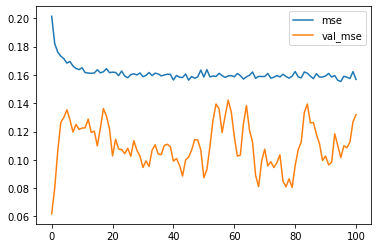

Prediction = 0.7500718235969543
Last corr = 0.952661
pred_col_name qqq_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
1.3680458029111227  minutes


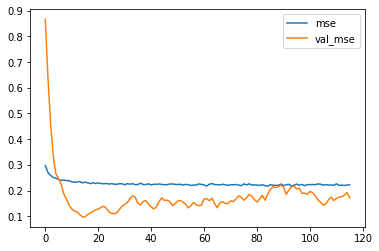

Prediction = 0.10071460902690887
Last corr = -0.158759
pred_col_name bku_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
1.408815602461497  minutes


Prediction = 0.8739556074142456
Last corr = 0.966783
pred_col_name hope_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2538646976153056  minutes


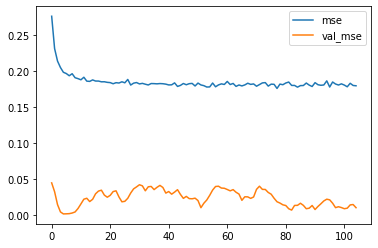

Prediction = 0.8731502294540405
Last corr = 0.929659
pred_col_name vno_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2062001665433248  minutes


Prediction = 0.7544399499893188
Last corr = 0.735034
pred_col_name hasi_cvcy_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.317438280582428  minutes


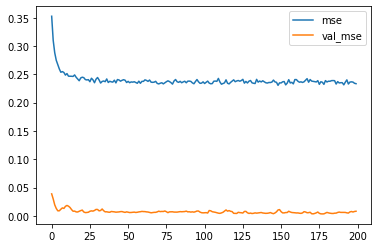

Prediction = 0.7643400430679321
Last corr = 0.568773
pred_col_name wal_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
1.70395876566569  minutes


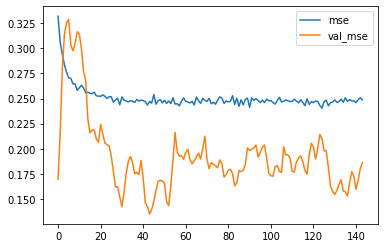

Prediction = 0.5476183891296387
Last corr = 0.876936
pred_col_name iwm_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.312638751665751  minutes


Prediction = 0.9358320832252502
Last corr = 0.925019
pred_col_name nrz_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2127395351727803  minutes


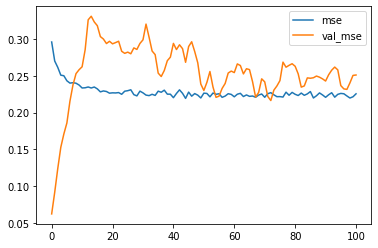

Prediction = 0.8479496836662292
Last corr = 0.865401
pred_col_name hasi_agnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.3158859848976134  minutes


Prediction = 0.5584513545036316
Last corr = 0.590637
pred_col_name cwbc_sui_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2052664041519165  minutes


Prediction = 0.566923975944519
Last corr = 0.742004
pred_col_name dlr_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
1.6548110167185466  minutes


Prediction = -0.16757938265800476
Last corr = -0.238038
pred_col_name ntrs_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
1.5834824721018472  minutes


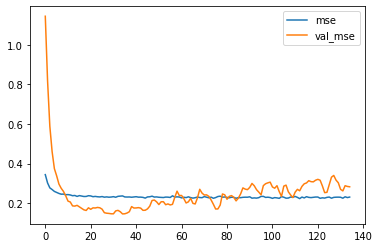

Prediction = 0.5333006381988525
Last corr = 0.892014
pred_col_name fitb_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.326524619261424  minutes


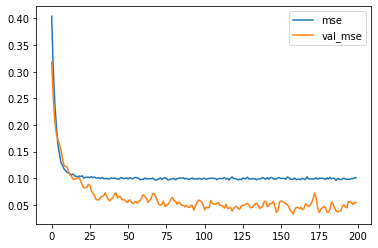

Prediction = 0.9107255935668945
Last corr = 0.990129
pred_col_name bsrr_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2499969720840454  minutes


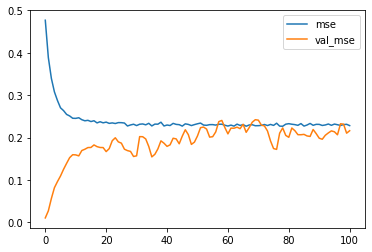

Prediction = 0.8901951313018799
Last corr = 0.858314
pred_col_name bmrc_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2014408826828002  minutes


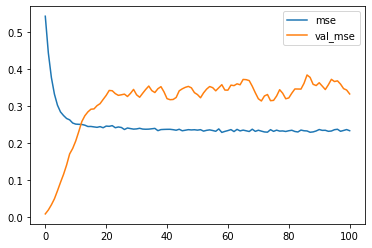

Prediction = 0.7833173274993896
Last corr = 0.852096
pred_col_name dlr_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2522071480751038  minutes


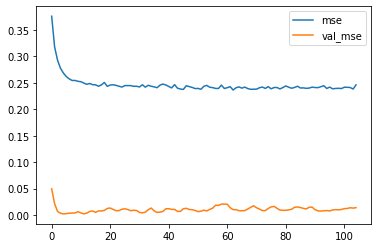

Prediction = 0.6472494602203369
Last corr = 0.560935
pred_col_name cvcy_bjk_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2013242324193318  minutes


Prediction = 0.5352777242660522
Last corr = 0.809433
pred_col_name wfc_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.3006583174069724  minutes


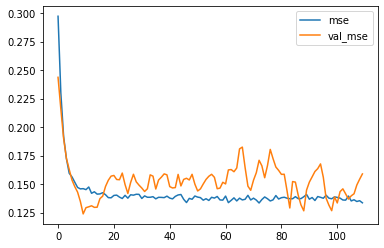

Prediction = 0.6508979797363281
Last corr = 0.977299
pred_col_name spy_hiw_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2071528355280559  minutes


Prediction = 0.7842376828193665
Last corr = 0.908734
pred_col_name hope_ntrs_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2080308198928833  minutes


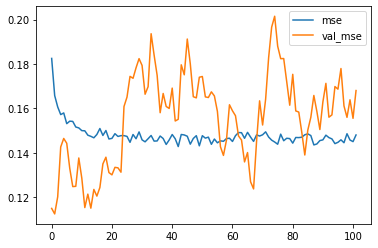

Prediction = 0.8270268440246582
Last corr = 0.971731
pred_col_name pfbc_vno_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1894004980723063  minutes


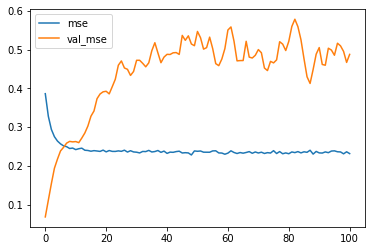

Prediction = 0.7493056058883667
Last corr = 0.913635
pred_col_name fitb_agnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
1.505754868189494  minutes


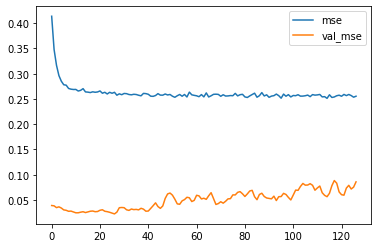

Prediction = 0.482577383518219
Last corr = 0.363801
pred_col_name vti_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
1.2672537843386331  minutes


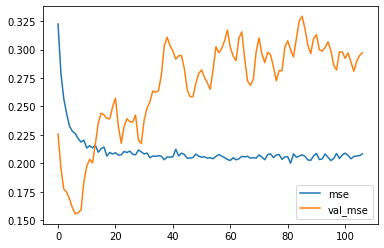

Prediction = 0.7021161317825317
Last corr = 0.969144
pred_col_name ubfo_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
1.9706889708836874  minutes


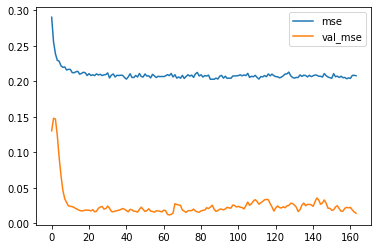

Prediction = 0.8510176539421082
Last corr = 0.804751
pred_col_name mtb_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.216050418217977  minutes


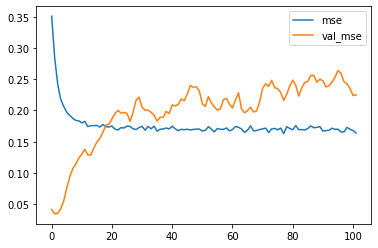

Prediction = 0.8807985186576843
Last corr = 0.893184
pred_col_name vfh_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2104689637819925  minutes


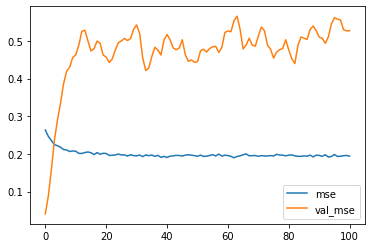

Prediction = 0.682781457901001
Last corr = 0.90667
pred_col_name bsrr_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2088401317596436  minutes


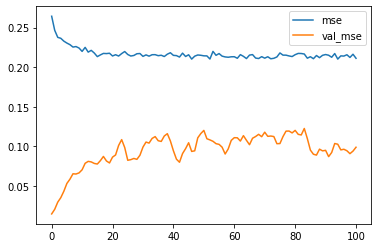

Prediction = 0.7515213489532471
Last corr = 0.755685
pred_col_name hasi_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.2146227478981018  minutes


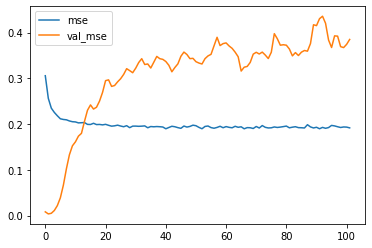

Prediction = 0.6272836923599243
Last corr = 0.577738
pred_col_name bsrr_agnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2161795655886332  minutes


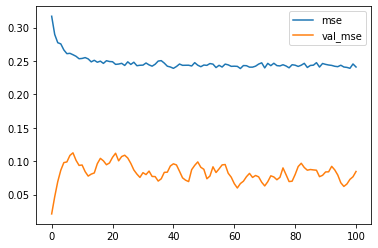

Prediction = 0.5918962359428406
Last corr = 0.719753
pred_col_name bsrr_sivb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3200156331062316  minutes


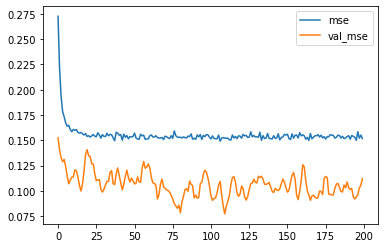

Prediction = 0.7440025806427002
Last corr = 0.813133
pred_col_name cvcy_c_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.217605185508728  minutes


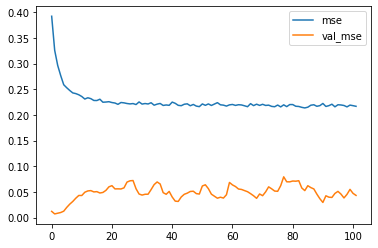

Prediction = 0.768082320690155
Last corr = 0.602067
pred_col_name spy_lamr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2176222681999207  minutes


Prediction = 0.8693275451660156
Last corr = -0.183253
pred_col_name agnc_pbj_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.2979417006174723  minutes


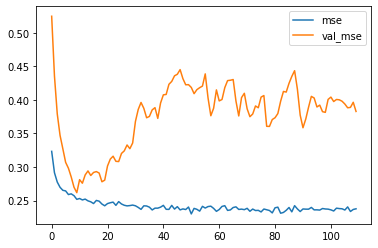

Prediction = 0.3820497393608093
Last corr = -0.058396
pred_col_name cwbc_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3149860501289368  minutes


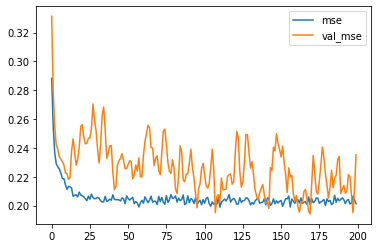

Prediction = 0.21564410626888275
Last corr = -0.311953
pred_col_name pbj_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
1.6860514799753825  minutes


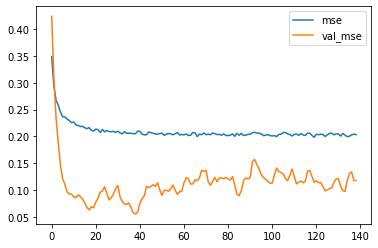

Prediction = 0.6066038608551025
Last corr = 0.791888
pred_col_name wal_key_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3357508341471354  minutes


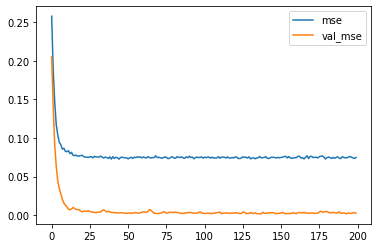

Prediction = 1.0086356401443481
Last corr = 0.981761
pred_col_name hiw_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.192340083916982  minutes


Prediction = 0.8961793184280396
Last corr = 0.961997
pred_col_name vti_colb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2248735467592875  minutes


Prediction = 0.8057557344436646
Last corr = 0.889716
pred_col_name jpm_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.232543687025706  minutes


Prediction = 0.9075167775154114
Last corr = 0.945228
pred_col_name pfbc_vfh_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00182: early stopping
2.1254035313924153  minutes


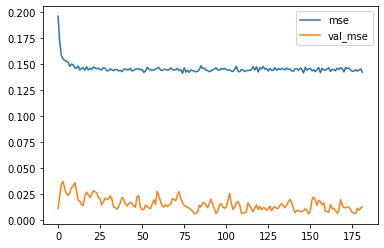

Prediction = 0.9474144577980042
Last corr = 0.960864
pred_col_name umpq_bku_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00123: early stopping
1.4473403175671895  minutes


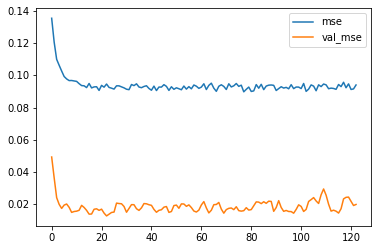

Prediction = 0.9729791283607483
Last corr = 0.917076
pred_col_name irm_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00116: early stopping
1.3775931318600974  minutes


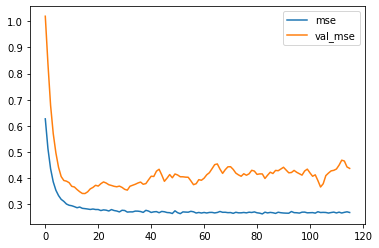

Prediction = 0.207299143075943
Last corr = -0.225651
pred_col_name qqq_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
1.5762903173764546  minutes


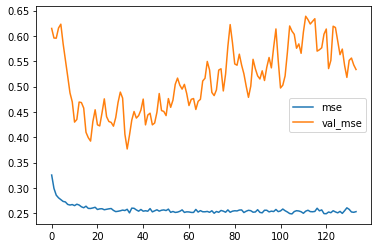

Prediction = 0.10830864310264587
Last corr = -0.39603
pred_col_name vti_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.289063815275828  minutes


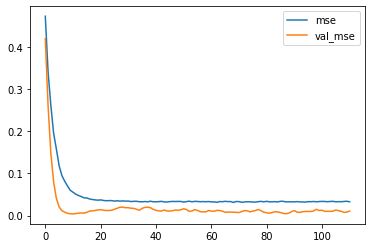

Prediction = 1.0706826448440552
Last corr = 0.991762
pred_col_name qqq_sui_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3339794834454852  minutes


Prediction = 0.4246661067008972
Last corr = 0.031943
pred_col_name fitb_nrz_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.3557380636533103  minutes


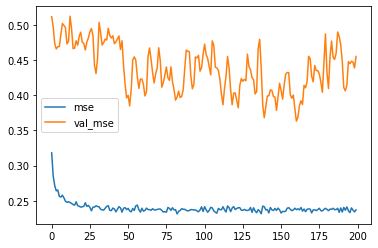

Prediction = 0.16313326358795166
Last corr = 0.915477
pred_col_name dlr_cma_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00163: early stopping
1.9090532819430033  minutes


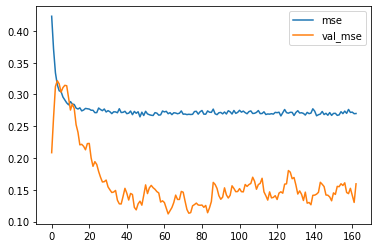

Prediction = 0.34287571907043457
Last corr = 0.727186
pred_col_name fitb_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.367159068584442  minutes


Prediction = 0.22311237454414368
Last corr = 0.840389
pred_col_name fsbw_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping
1.3053308327992756  minutes


Prediction = 0.7214356064796448
Last corr = 0.826182
pred_col_name cwbc_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
1.3025253494580586  minutes


Prediction = 0.3991469442844391
Last corr = 0.429007
pred_col_name dlr_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.2027395844459534  minutes


Prediction = 0.3422147035598755
Last corr = 0.667633
pred_col_name ubfo_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00103: early stopping
1.2314612865447998  minutes


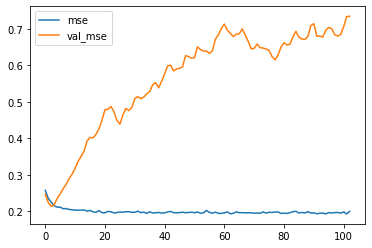

Prediction = 0.4275466799736023
Last corr = 0.783315
pred_col_name gbci_vti_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping
1.325174097220103  minutes


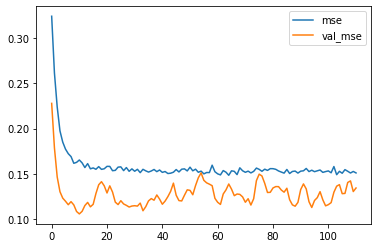

Prediction = 0.6180789470672607
Last corr = 0.885127
pred_col_name nrz_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.35993378162384  minutes


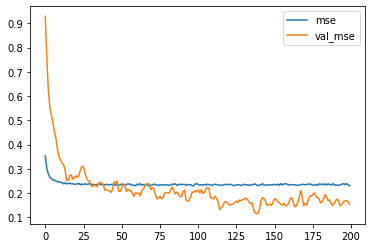

Prediction = -0.045740362256765366
Last corr = -0.335937
pred_col_name gbci_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00141: early stopping
1.701698633035024  minutes


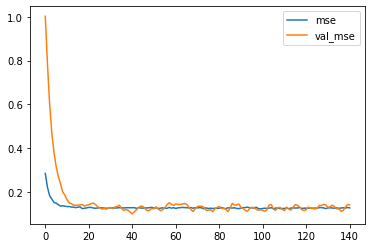

Prediction = 0.7561200857162476
Last corr = 0.981544
pred_col_name jpm_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping
1.9845792174339294  minutes


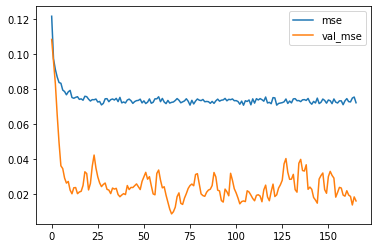

Prediction = 0.9049571752548218
Last corr = 0.979796
pred_col_name umpq_dre_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.213727335135142  minutes


Prediction = 0.7885530591011047
Last corr = 0.772437
pred_col_name ubfo_bac_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.1949650208155314  minutes


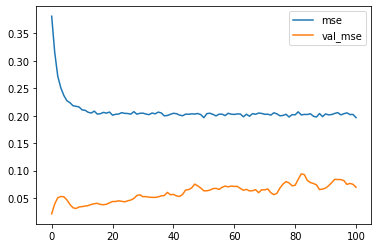

Prediction = 0.7955213189125061
Last corr = 0.90121
pred_col_name cwbc_dlr_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.2923447807629904  minutes


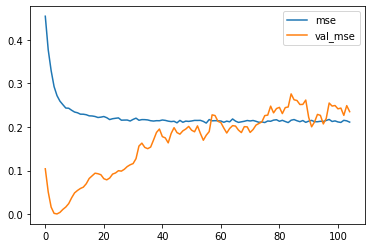

Prediction = 0.3091318607330322
Last corr = 0.344282
pred_col_name pej_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00105: early stopping
1.4242123126983643  minutes


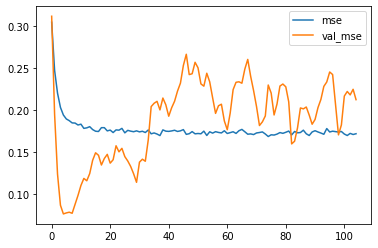

Prediction = 0.72689288854599
Last corr = 0.954519
pred_col_name irm_are_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.4757404804229735  minutes


Prediction = 1.0674573183059692
Last corr = 0.974823
pred_col_name bmrc_reg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.388230530420939  minutes


Prediction = 0.6716709733009338
Last corr = 0.848026
pred_col_name iwm_caty_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00104: early stopping
1.2806637167930603  minutes


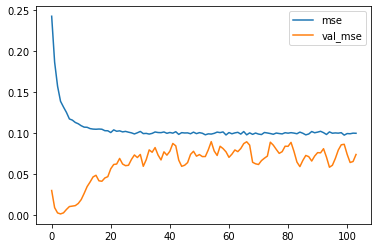

Prediction = 0.9438497424125671
Last corr = 0.971924
pred_col_name fsbw_pfbc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.3035669485727945  minutes


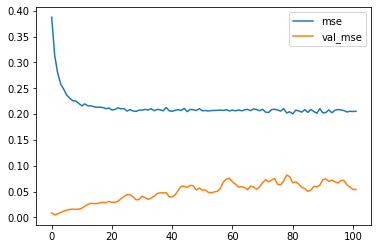

Prediction = 0.7832110524177551
Last corr = 0.831199
pred_col_name cvbf_ubfo_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.3907169699668884  minutes


Prediction = 0.8481457829475403
Last corr = 0.88684
pred_col_name pei_cpt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00181: early stopping
2.278483780225118  minutes


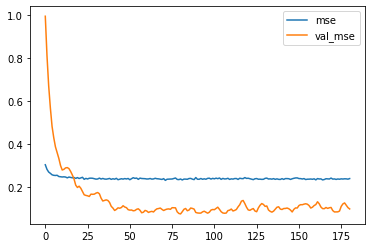

Prediction = 0.08671148121356964
Last corr = -0.241768
pred_col_name qqq_frc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping
1.22313334941864  minutes


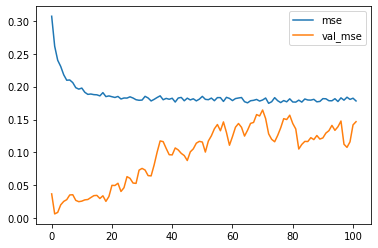

Prediction = 0.28140032291412354
Last corr = 0.308475
pred_col_name vfh_hope_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
2.167377547423045  minutes


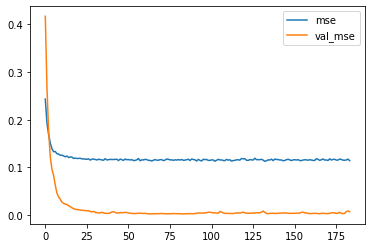

Prediction = 0.9466854929924011
Last corr = 0.944212
pred_col_name sui_cpg_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping
1.2828712662061055  minutes


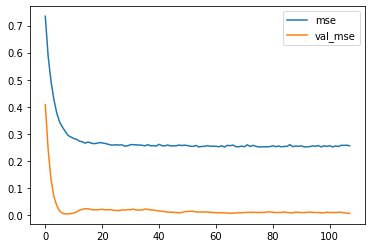

Prediction = 0.1687452346086502
Last corr = 0.217877
pred_col_name agnc_pnc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00101: early stopping
1.212997070948283  minutes


Prediction = 0.15629540383815765
Last corr = 0.149911
pred_col_name pfbc_dia_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
1.3016351024309794  minutes


Prediction = 0.6704703569412231
Last corr = 0.901369
pred_col_name sivb_pei_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
1.4252649982770285  minutes


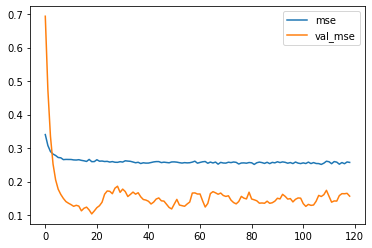

Prediction = 0.21585407853126526
Last corr = -0.234983
pred_col_name cwbc_bmrc_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
2.599687131245931  minutes


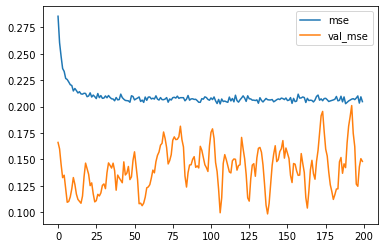

Prediction = 0.11382526904344559
Last corr = 0.498892
pred_col_name fsbw_mtb_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
1.9668468316396077  minutes


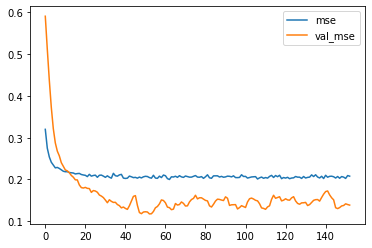

Prediction = 0.6345047354698181
Last corr = 0.904784
pred_col_name qqq_pej_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00171: early stopping
2.257804548740387  minutes


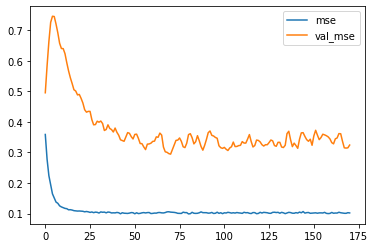

Prediction = 0.6829808950424194
Last corr = 0.134846
pred_col_name bsrr_boch_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782
Pct finished = 0.704225352112676
Pct finished = 0.7682458386683739
Pct finished = 0.8322663252240717
Pct finished = 0.8962868117797695
Pct finished = 0.9603072983354674
Training idx end at 1543
Total idx checked 1563
Val idx start at 1544
Val idx end at 1563
X val shape (5, 14, 12444)
Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
1.5984283645947774  minutes


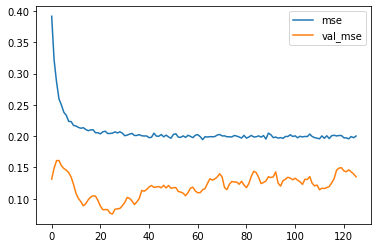

Prediction = 0.8150983452796936
Last corr = 0.961983
pred_col_name gbci_stt_close_corr_rolling_7_days
n_sequences 1562
Training idx start at 0
Pct finished = 0.06402048655569782
Pct finished = 0.12804097311139565
Pct finished = 0.19206145966709348
Pct finished = 0.2560819462227913
Pct finished = 0.3201024327784891
Pct finished = 0.38412291933418696
Pct finished = 0.44814340588988477
Pct finished = 0.5121638924455826
Pct finished = 0.5761843790012804
Pct finished = 0.6402048655569782


In [ ]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  


# so the solution was less validation data

# wal_cwbc is turns out needed less training data

# test a new model for each pair, 200 epochs per . 2 minutes per 200 epochs
# 300 pairs take 10 hours sequentially
# X,y, X_val, y_val, scalers, pca_scalers 
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks[:500], input_verbose=0)

In [ ]:
training_data

In [ ]:
np.isnan(X_val).sum()

In [1021]:
np.isnan(new_X_test).sum()

0